In [11]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import csv

In [12]:
#matplotlib function that will plot the graphs
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Individual Districts

In [15]:
#same procedure follows for each province
#open csv, ignore header, each row is counted as a timestep
#plot cases against timesteps
def open_and_read(district):
    time_step = []
    cases = []
    with open(f'../final district csvs/{district}.csv') as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      next(reader)
      steps = 0
      for row in reader:
        cases.append(float(row[-1]))
        time_step.append(steps)
        steps+=1

    series = np.array(cases)
    time = np.array(time_step)
    plt.figure(figsize=(10, 6))
    plot_series(time, series)
    
    return series, time

In [16]:
def steps_split(split, district):
    split_time = split
    series, time = open_and_read(district)
    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]
    
    return time_train, x_train, time_valid, x_valid

In [33]:
def create_model(shuffle, window, batch, epochs, split, district):
    time_train, x_train, time_valid, x_valid = steps_split(split, district)
    shuffle_buffer_size = shuffle
    window_size = window
    batch_size = batch
    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    model_central = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    #stochastic gradient descent used for optimization
    optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

    #compile using huber loss and mean absolute error
    model_central.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history_central = model_central.fit(train_set, epochs=epochs)
    model_central.save(f"../models/districts/lstm-model-{district}-district.h5")
    return history_central, model_central

In [58]:
shuffle_buffer_size = 10
window_size = 5
batch_size = 5
epochs = 300
split = 10

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 12.9725 - mae: 13.4725
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 12.9682 - mae: 13.4682
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 12.9602 - mae: 13.4602
Epoch 4/300
1/1 [==============================] - 0s 1ms/step - loss: 12.9487 - mae: 13.4487
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 12.9341 - mae: 13.4341
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 12.9168 - mae: 13.4168
Epoch 7/300
1/1 [==============================] - 0s 998us/step - loss: 12.8969 - mae: 13.3969
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 12.8748 - mae: 13.3748
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 12.8507 - mae: 13.3507
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 12.8247 - mae: 13.3247
Epoch 11/300
1/1 [==============================] - 0s 99

1/1 [==============================] - 0s 997us/step - loss: 7.3004 - mae: 7.7741
Epoch 173/300
1/1 [==============================] - 0s 1ms/step - loss: 7.2815 - mae: 7.7543
Epoch 174/300
1/1 [==============================] - 0s 996us/step - loss: 7.2628 - mae: 7.7346
Epoch 175/300
1/1 [==============================] - 0s 997us/step - loss: 7.2444 - mae: 7.7150
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 7.2262 - mae: 7.6956
Epoch 177/300
1/1 [==============================] - 0s 995us/step - loss: 7.2082 - mae: 7.6769
Epoch 178/300
1/1 [==============================] - 0s 998us/step - loss: 7.1907 - mae: 7.6600
Epoch 179/300
1/1 [==============================] - 0s 2ms/step - loss: 7.1735 - mae: 7.6432
Epoch 180/300
1/1 [==============================] - 0s 1ms/step - loss: 7.1565 - mae: 7.6265
Epoch 181/300
1/1 [==============================] - 0s 997us/step - loss: 7.1396 - mae: 7.6100
Epoch 182/300
1/1 [==============================] - 0s 998u

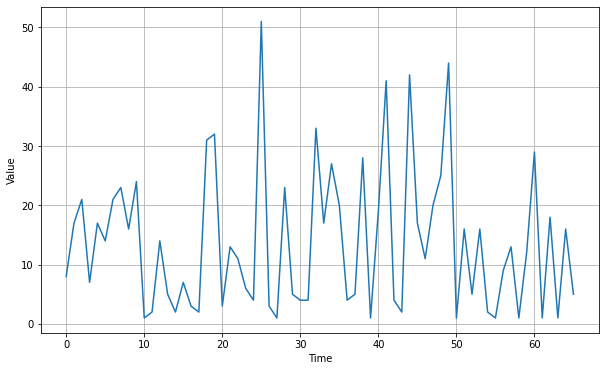

In [27]:
district = 'Ampara'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

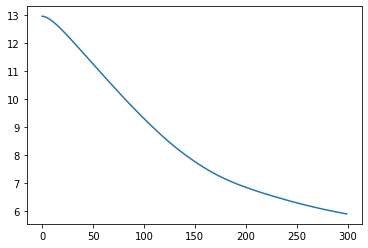

In [28]:
plt.plot(history_central.history['loss'])

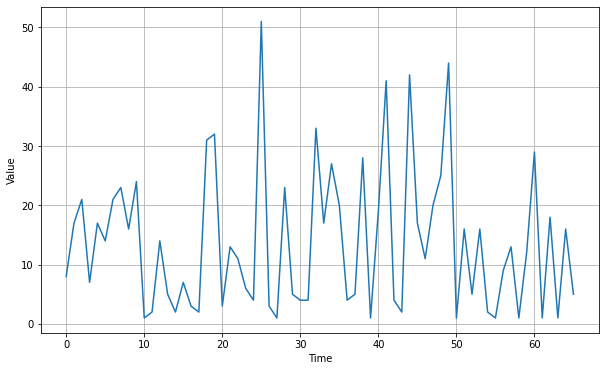

In [29]:
series, time = open_and_read(district)

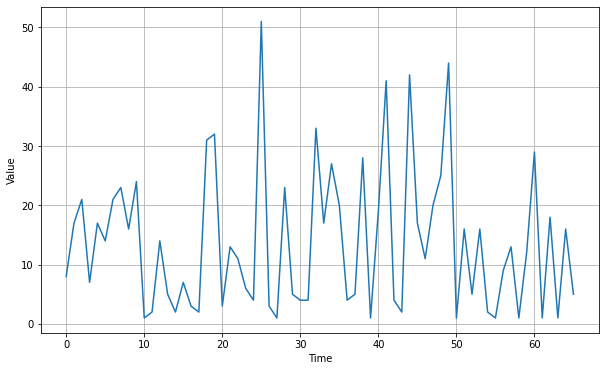

In [30]:
time_train, x_train, time_valid, x_valid = steps_split(split, district)

In [31]:
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]

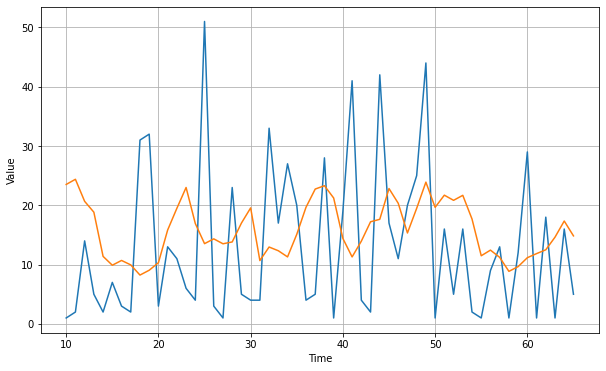

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 4.6143 - mae: 5.1142
Epoch 2/300
1/1 [==============================] - 0s 997us/step - loss: 4.6117 - mae: 5.1116
Epoch 3/300
1/1 [==============================] - 0s 998us/step - loss: 4.6068 - mae: 5.1066
Epoch 4/300
1/1 [==============================] - 0s 998us/step - loss: 4.5998 - mae: 5.0995
Epoch 5/300
1/1 [==============================] - 0s 997us/step - loss: 4.5909 - mae: 5.0906
Epoch 6/300
1/1 [==============================] - 0s 998us/step - loss: 4.5804 - mae: 5.0800
Epoch 7/300
1/1 [==============================] - 0s 998us/step - loss: 4.5683 - mae: 5.0678
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 4.5550 - mae: 5.0543
Epoch 9/300
1/1 [==============================] - 0s 997us/step - loss: 4.5406 - mae: 5.0397
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 4.5251 - mae: 5.0239
Epoch 11/300
1/1 [==============================] - 0s 2ms/step -

1/1 [==============================] - 0s 1ms/step - loss: 2.8437 - mae: 3.3121
Epoch 175/300
1/1 [==============================] - 0s 981us/step - loss: 2.8412 - mae: 3.3095
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 2.8388 - mae: 3.3069
Epoch 177/300
1/1 [==============================] - 0s 999us/step - loss: 2.8364 - mae: 3.3043
Epoch 178/300
1/1 [==============================] - 0s 1ms/step - loss: 2.8340 - mae: 3.3017
Epoch 179/300
1/1 [==============================] - 0s 996us/step - loss: 2.8316 - mae: 3.2991
Epoch 180/300
1/1 [==============================] - 0s 0s/step - loss: 2.8293 - mae: 3.2965
Epoch 181/300
1/1 [==============================] - 0s 1ms/step - loss: 2.8269 - mae: 3.2940
Epoch 182/300
1/1 [==============================] - 0s 1ms/step - loss: 2.8246 - mae: 3.2915
Epoch 183/300
1/1 [==============================] - 0s 1ms/step - loss: 2.8224 - mae: 3.2890
Epoch 184/300
1/1 [==============================] - 0s 997us/step 

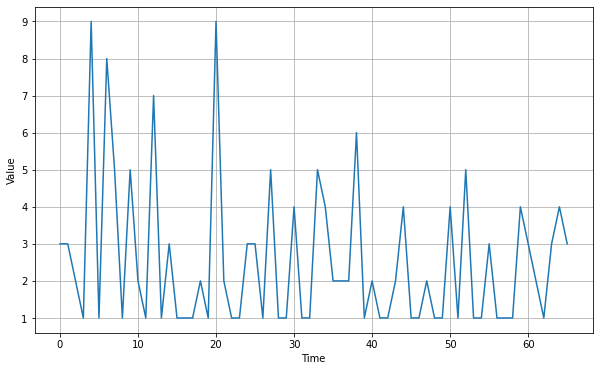

In [35]:
district = 'Anuradhapura'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

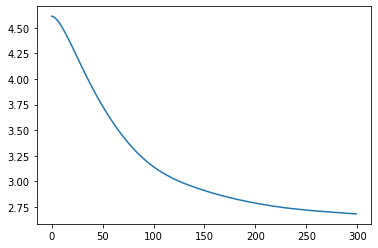

In [36]:
plt.plot(history_central.history['loss'])

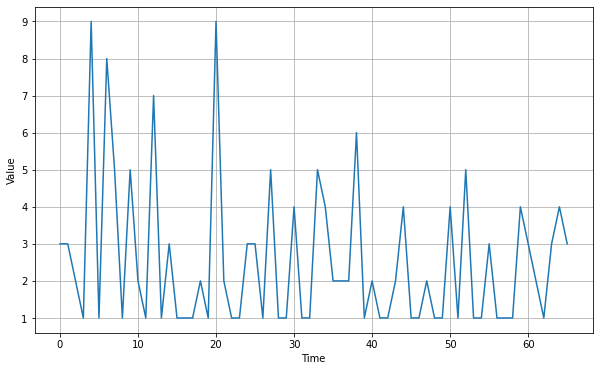

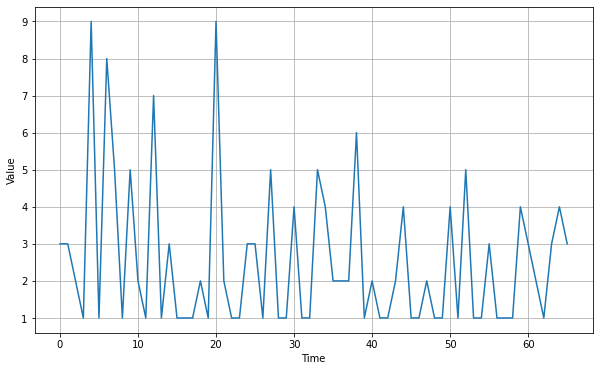

In [37]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)

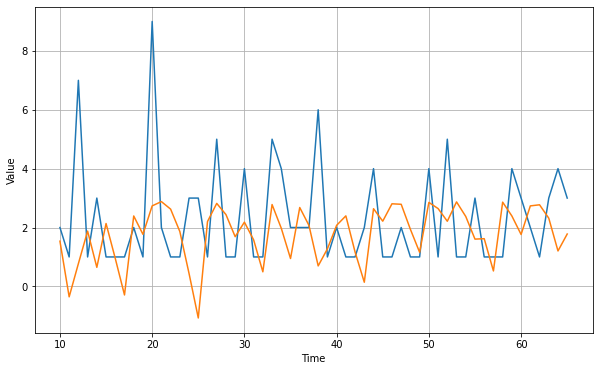

In [38]:
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 2.8788 - mae: 3.3716
Epoch 2/300
1/1 [==============================] - 0s 997us/step - loss: 2.8742 - mae: 3.3668
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 2.8655 - mae: 3.3576
Epoch 4/300
1/1 [==============================] - 0s 997us/step - loss: 2.8531 - mae: 3.3445
Epoch 5/300
1/1 [==============================] - 0s 999us/step - loss: 2.8374 - mae: 3.3280
Epoch 6/300
1/1 [==============================] - 0s 990us/step - loss: 2.8188 - mae: 3.3082
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 2.7976 - mae: 3.2857
Epoch 8/300
1/1 [==============================] - 0s 999us/step - loss: 2.7743 - mae: 3.2607
Epoch 9/300
1/1 [==============================] - 0s 1ms/step - loss: 2.7490 - mae: 3.2336
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 2.7222 - mae: 3.2045
Epoch 11/300
1/1 [==============================] - 0s 999us/step - l

1/1 [==============================] - 0s 998us/step - loss: 1.2517 - mae: 1.6759
Epoch 175/300
1/1 [==============================] - 0s 1ms/step - loss: 1.2515 - mae: 1.6760
Epoch 176/300
1/1 [==============================] - 0s 999us/step - loss: 1.2513 - mae: 1.6762
Epoch 177/300
1/1 [==============================] - 0s 998us/step - loss: 1.2511 - mae: 1.6763
Epoch 178/300
1/1 [==============================] - 0s 0s/step - loss: 1.2510 - mae: 1.6764
Epoch 179/300
1/1 [==============================] - 0s 998us/step - loss: 1.2508 - mae: 1.6765
Epoch 180/300
1/1 [==============================] - 0s 998us/step - loss: 1.2506 - mae: 1.6766
Epoch 181/300
1/1 [==============================] - 0s 989us/step - loss: 1.2504 - mae: 1.6767
Epoch 182/300
1/1 [==============================] - 0s 998us/step - loss: 1.2503 - mae: 1.6768
Epoch 183/300
1/1 [==============================] - 0s 2ms/step - loss: 1.2501 - mae: 1.6769
Epoch 184/300
1/1 [==============================] - 0s 997us

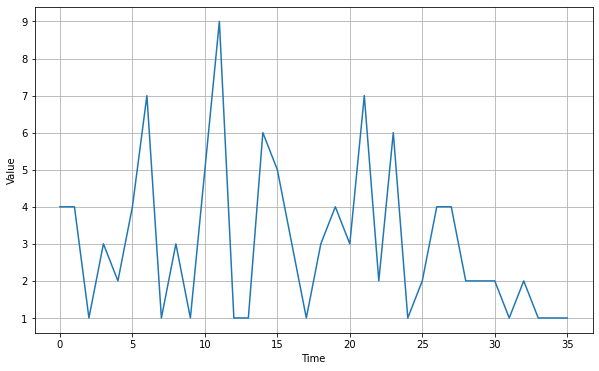

In [42]:
district = 'Badulla'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

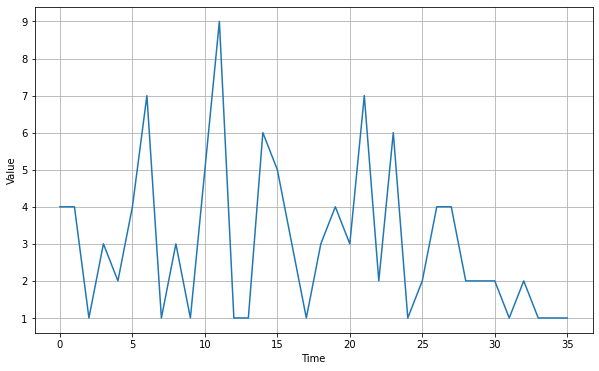

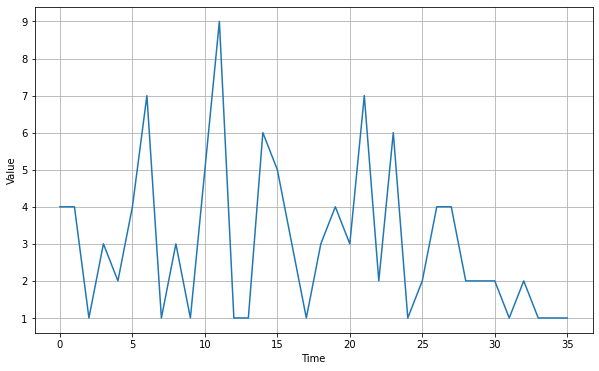

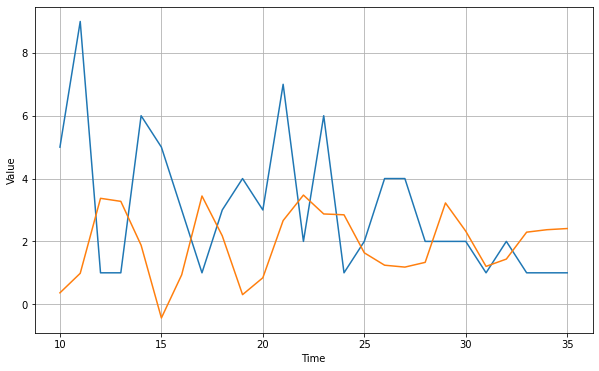

In [43]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 1.3921 - mae: 1.8921
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3869 - mae: 1.8869
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 1.3771 - mae: 1.8771
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3631 - mae: 1.8631
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 1.3454 - mae: 1.8454
Epoch 6/300
1/1 [==============================] - 0s 996us/step - loss: 1.3245 - mae: 1.8245
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 1.3006 - mae: 1.8005
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 1.2744 - mae: 1.7742
Epoch 9/300
1/1 [==============================] - 0s 999us/step - loss: 1.2468 - mae: 1.7464
Epoch 10/300
1/1 [==============================] - 0s 0s/step - loss: 1.2176 - mae: 1.7168
Epoch 11/300
1/1 [==============================] - 0s 980us/step - loss: 1.

1/1 [==============================] - 0s 1ms/step - loss: 0.3678 - mae: 0.6546
Epoch 175/300
1/1 [==============================] - 0s 2ms/step - loss: 0.3678 - mae: 0.6546
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 0.3677 - mae: 0.6546
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3677 - mae: 0.6545
Epoch 178/300
1/1 [==============================] - 0s 998us/step - loss: 0.3677 - mae: 0.6545
Epoch 179/300
1/1 [==============================] - 0s 999us/step - loss: 0.3676 - mae: 0.6545
Epoch 180/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3676 - mae: 0.6545
Epoch 181/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3676 - mae: 0.6545
Epoch 182/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3675 - mae: 0.6544
Epoch 183/300
1/1 [==============================] - 0s 2ms/step - loss: 0.3675 - mae: 0.6544
Epoch 184/300
1/1 [==============================] - 0s 998us/step -

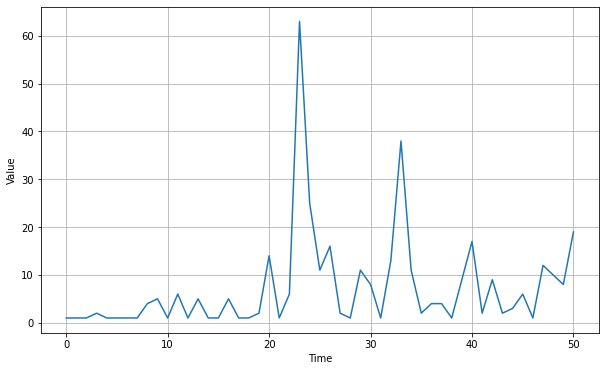

In [44]:
district = 'Batticaloa'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

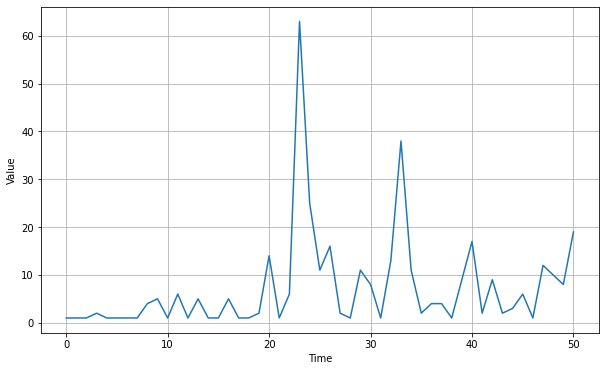

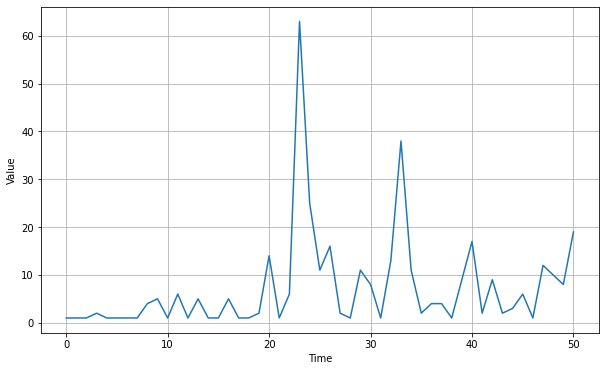

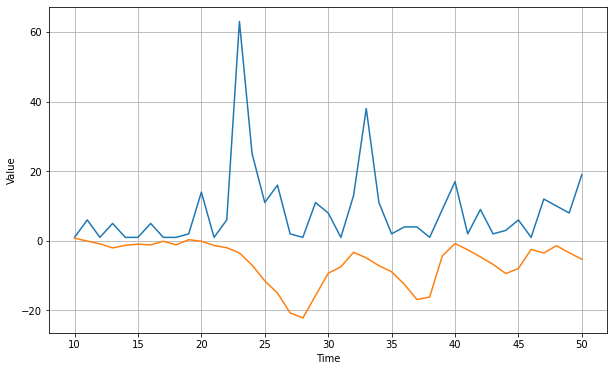

In [45]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 113.4656 - mae: 113.8808
Epoch 2/300
1/1 [==============================] - 0s 997us/step - loss: 113.4655 - mae: 113.8807
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 113.4654 - mae: 113.8805
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 113.4652 - mae: 113.8803
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 113.4649 - mae: 113.8800
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 113.4647 - mae: 113.8797
Epoch 7/300
1/1 [==============================] - 0s 997us/step - loss: 113.4644 - mae: 113.8794
Epoch 8/300
1/1 [==============================] - 0s 999us/step - loss: 113.4641 - mae: 113.8791
Epoch 9/300
1/1 [==============================] - 0s 0s/step - loss: 113.4638 - mae: 113.8787
Epoch 10/300
1/1 [==============================] - 0s 0s/step - loss: 113.4634 - mae: 113.8784
Epoch 11/300
1/1 [=================

Epoch 85/300
1/1 [==============================] - 0s 0s/step - loss: 113.4397 - mae: 113.8519
Epoch 86/300
1/1 [==============================] - 0s 2ms/step - loss: 113.4394 - mae: 113.8516
Epoch 87/300
1/1 [==============================] - 0s 997us/step - loss: 113.4391 - mae: 113.8512
Epoch 88/300
1/1 [==============================] - 0s 0s/step - loss: 113.4388 - mae: 113.8509
Epoch 89/300
1/1 [==============================] - 0s 996us/step - loss: 113.4385 - mae: 113.8506
Epoch 90/300
1/1 [==============================] - 0s 997us/step - loss: 113.4382 - mae: 113.8502
Epoch 91/300
1/1 [==============================] - 0s 0s/step - loss: 113.4380 - mae: 113.8499
Epoch 92/300
1/1 [==============================] - 0s 0s/step - loss: 113.4377 - mae: 113.8496
Epoch 93/300
1/1 [==============================] - 0s 996us/step - loss: 113.4374 - mae: 113.8493
Epoch 94/300
1/1 [==============================] - 0s 1ms/step - loss: 113.4371 - mae: 113.8489
Epoch 95/300
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 113.4010 - mae: 113.8023
Epoch 250/300
1/1 [==============================] - 0s 998us/step - loss: 113.4008 - mae: 113.8020
Epoch 251/300
1/1 [==============================] - 0s 0s/step - loss: 113.4007 - mae: 113.8018
Epoch 252/300
1/1 [==============================] - 0s 2ms/step - loss: 113.4004 - mae: 113.8015
Epoch 253/300
1/1 [==============================] - 0s 1ms/step - loss: 113.4002 - mae: 113.8012
Epoch 254/300
1/1 [==============================] - 0s 2ms/step - loss: 113.4000 - mae: 113.8010
Epoch 255/300
1/1 [==============================] - 0s 2ms/step - loss: 113.3998 - mae: 113.8007
Epoch 256/300
1/1 [==============================] - 0s 979us/step - loss: 113.3996 - mae: 113.8005
Epoch 257/300
1/1 [==============================] - 0s 0s/step - loss: 113.3994 - mae: 113.8002
Epoch 258/300
1/1 [==============================] - 0s 1ms/step - loss: 113.3992 - mae: 113.7999
Epoch 259/300
1/1 [=============

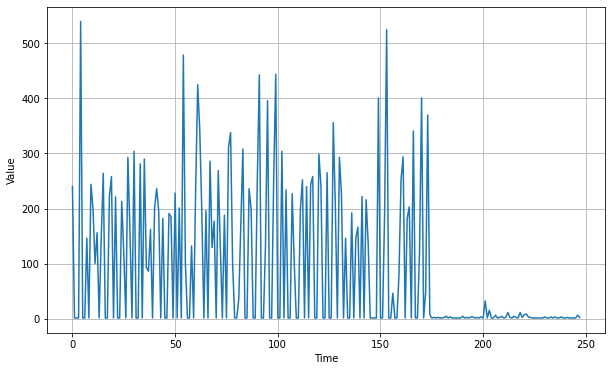

In [46]:
district = 'Colombo'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

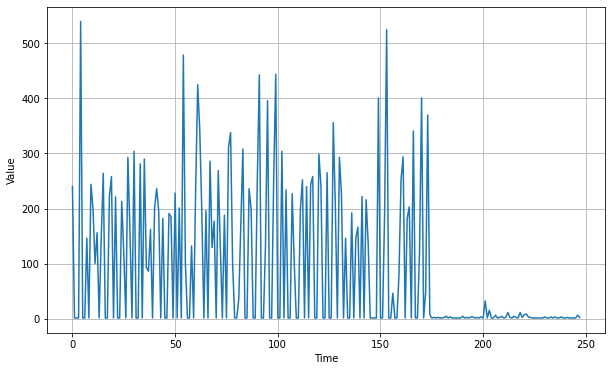

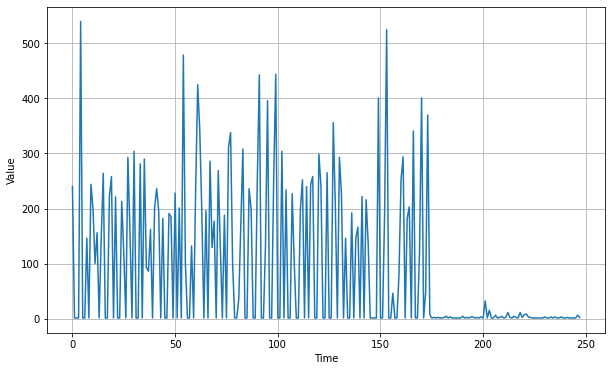

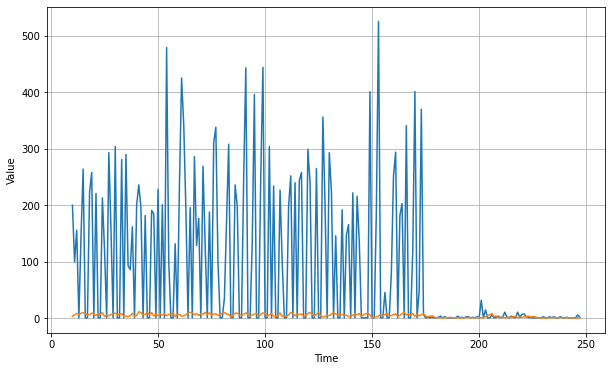

In [47]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 10ms/step - loss: 15.4176 - mae: 15.9176
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 15.4153 - mae: 15.9153
Epoch 3/300
1/1 [==============================] - 0s 1000us/step - loss: 15.4111 - mae: 15.9111
Epoch 4/300
1/1 [==============================] - 0s 997us/step - loss: 15.4051 - mae: 15.9051
Epoch 5/300
1/1 [==============================] - 0s 982us/step - loss: 15.3974 - mae: 15.8974
Epoch 6/300
1/1 [==============================] - 0s 0s/step - loss: 15.3884 - mae: 15.8884
Epoch 7/300
1/1 [==============================] - 0s 998us/step - loss: 15.3781 - mae: 15.8781
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 15.3666 - mae: 15.8666
Epoch 9/300
1/1 [==============================] - 0s 1ms/step - loss: 15.3541 - mae: 15.8541
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 15.3407 - mae: 15.8407
Epoch 11/300
1/1 [==============================] 

1/1 [==============================] - 0s 997us/step - loss: 13.4647 - mae: 13.9029
Epoch 171/300
1/1 [==============================] - 0s 1ms/step - loss: 13.4605 - mae: 13.8984
Epoch 172/300
1/1 [==============================] - 0s 2ms/step - loss: 13.4563 - mae: 13.8942
Epoch 173/300
1/1 [==============================] - 0s 997us/step - loss: 13.4522 - mae: 13.8915
Epoch 174/300
1/1 [==============================] - 0s 2ms/step - loss: 13.4481 - mae: 13.8889
Epoch 175/300
1/1 [==============================] - 0s 998us/step - loss: 13.4441 - mae: 13.8862
Epoch 176/300
1/1 [==============================] - 0s 2ms/step - loss: 13.4401 - mae: 13.8836
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 13.4362 - mae: 13.8810
Epoch 178/300
1/1 [==============================] - 0s 1ms/step - loss: 13.4323 - mae: 13.8784
Epoch 179/300
1/1 [==============================] - 0s 994us/step - loss: 13.4285 - mae: 13.8759
Epoch 180/300
1/1 [===========================

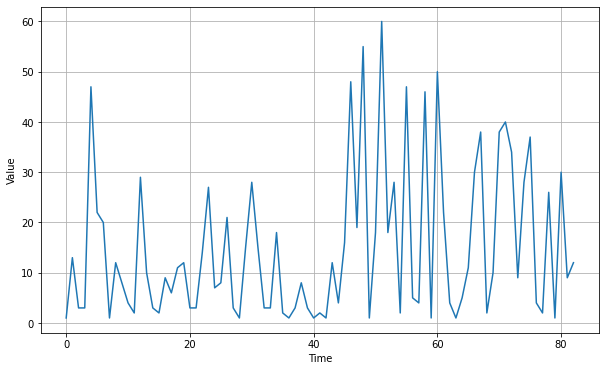

In [48]:
district = 'Galle'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

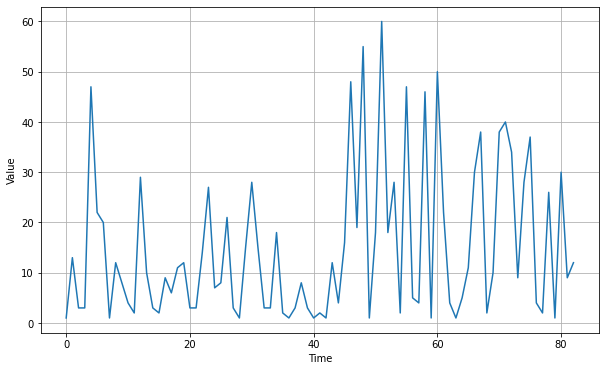

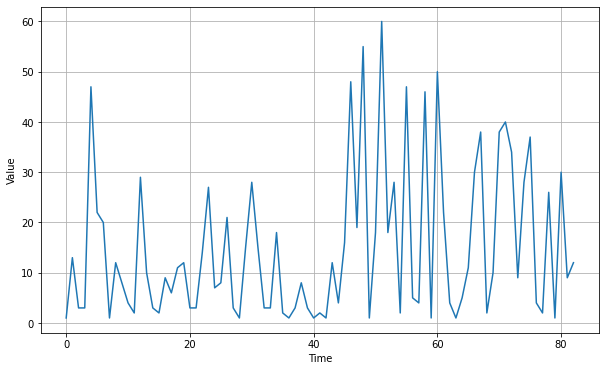

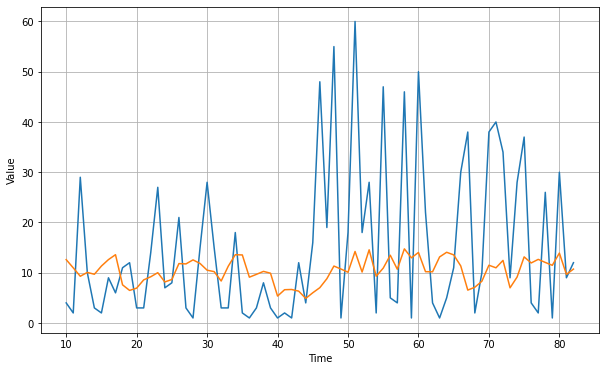

In [49]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 105.5051 - mae: 106.0051
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 105.5004 - mae: 106.0004
Epoch 3/300
1/1 [==============================] - 0s 0s/step - loss: 105.4914 - mae: 105.9914
Epoch 4/300
1/1 [==============================] - 0s 997us/step - loss: 105.4787 - mae: 105.9787
Epoch 5/300
1/1 [==============================] - 0s 997us/step - loss: 105.4625 - mae: 105.9625
Epoch 6/300
1/1 [==============================] - 0s 0s/step - loss: 105.4433 - mae: 105.9433
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 105.4212 - mae: 105.9213
Epoch 8/300
1/1 [==============================] - 0s 0s/step - loss: 105.3967 - mae: 105.8967
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 105.3700 - mae: 105.8700
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 105.3416 - mae: 105.8416
Epoch 11/300
1/1 [====================

1/1 [==============================] - 0s 983us/step - loss: 98.7131 - mae: 99.1941
Epoch 168/300
1/1 [==============================] - 0s 996us/step - loss: 98.6772 - mae: 99.1573
Epoch 169/300
1/1 [==============================] - 0s 998us/step - loss: 98.6413 - mae: 99.1226
Epoch 170/300
1/1 [==============================] - 0s 997us/step - loss: 98.6056 - mae: 99.0880
Epoch 171/300
1/1 [==============================] - 0s 999us/step - loss: 98.5701 - mae: 99.0535
Epoch 172/300
1/1 [==============================] - 0s 997us/step - loss: 98.5352 - mae: 99.0196
Epoch 173/300
1/1 [==============================] - 0s 998us/step - loss: 98.5003 - mae: 98.9858
Epoch 174/300
1/1 [==============================] - 0s 994us/step - loss: 98.4656 - mae: 98.9520
Epoch 175/300
1/1 [==============================] - 0s 1ms/step - loss: 98.4310 - mae: 98.9183
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 98.3965 - mae: 98.8847
Epoch 177/300
1/1 [=================

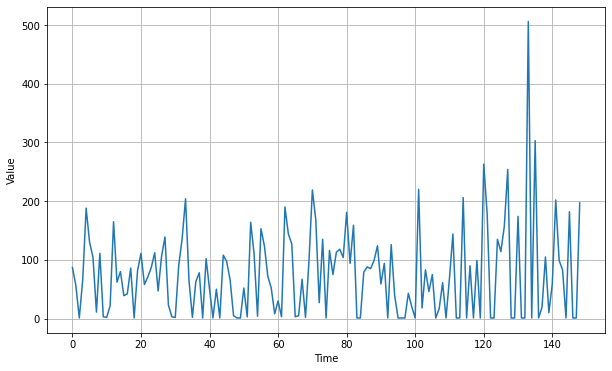

In [50]:
district = 'Gampaha'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

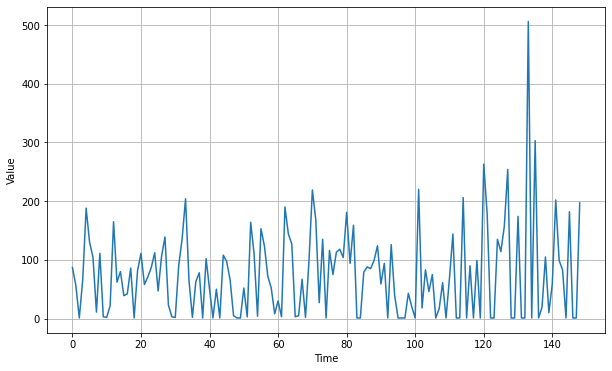

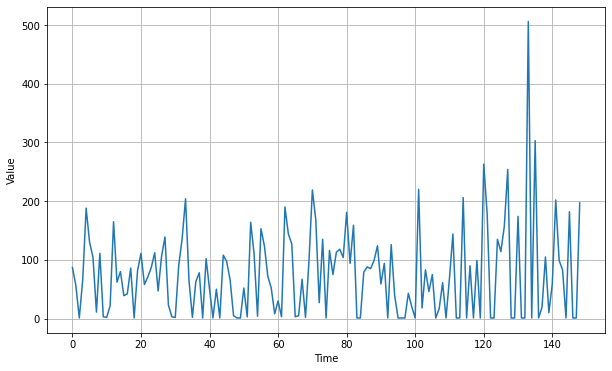

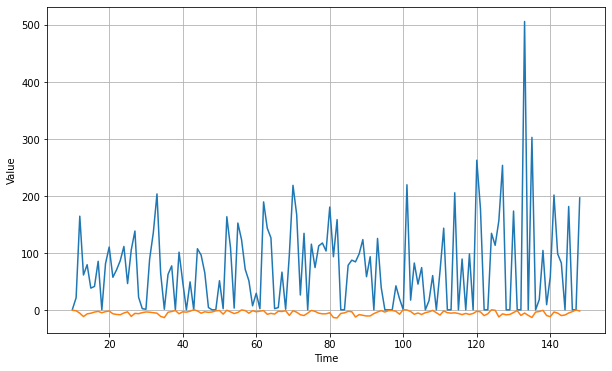

In [51]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 14.5219 - mae: 15.0219
Epoch 2/300
1/1 [==============================] - 0s 997us/step - loss: 14.5169 - mae: 15.0169
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 14.5075 - mae: 15.0075
Epoch 4/300
1/1 [==============================] - 0s 996us/step - loss: 14.4940 - mae: 14.9940
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 14.4769 - mae: 14.9769
Epoch 6/300
1/1 [==============================] - 0s 988us/step - loss: 14.4571 - mae: 14.9571
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 14.4345 - mae: 14.9345
Epoch 8/300
1/1 [==============================] - 0s 997us/step - loss: 14.4098 - mae: 14.9098
Epoch 9/300
1/1 [==============================] - 0s 993us/step - loss: 14.3829 - mae: 14.8829
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 14.3541 - mae: 14.8541
Epoch 11/300
1/1 [==============================]

1/1 [==============================] - 0s 1ms/step - loss: 10.4574 - mae: 10.9163
Epoch 171/300
1/1 [==============================] - 0s 997us/step - loss: 10.4518 - mae: 10.9121
Epoch 172/300
1/1 [==============================] - 0s 998us/step - loss: 10.4461 - mae: 10.9078
Epoch 173/300
1/1 [==============================] - 0s 998us/step - loss: 10.4404 - mae: 10.9035
Epoch 174/300
1/1 [==============================] - 0s 1ms/step - loss: 10.4348 - mae: 10.8991
Epoch 175/300
1/1 [==============================] - 0s 1ms/step - loss: 10.4293 - mae: 10.8948
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 10.4238 - mae: 10.8905
Epoch 177/300
1/1 [==============================] - 0s 2ms/step - loss: 10.4183 - mae: 10.8862
Epoch 178/300
1/1 [==============================] - 0s 997us/step - loss: 10.4129 - mae: 10.8819
Epoch 179/300
1/1 [==============================] - 0s 998us/step - loss: 10.4076 - mae: 10.8776
Epoch 180/300
1/1 [=======================

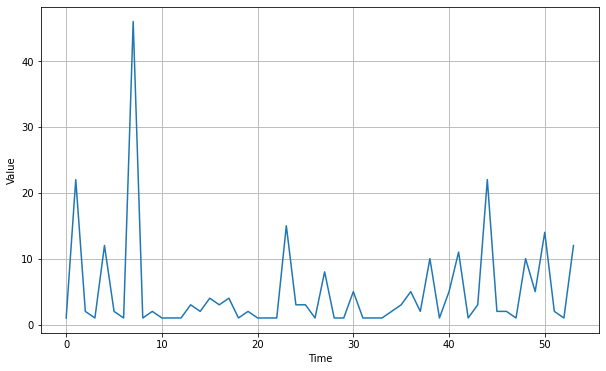

In [52]:
district = 'Hambantota'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

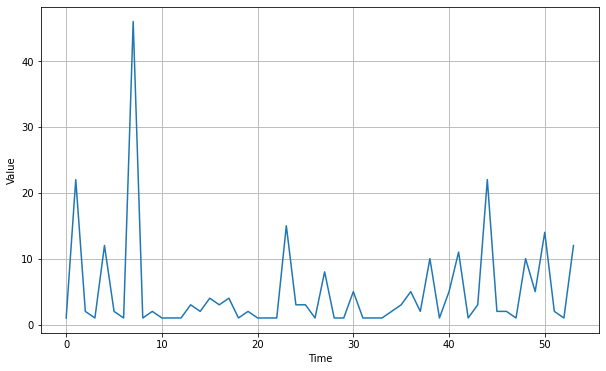

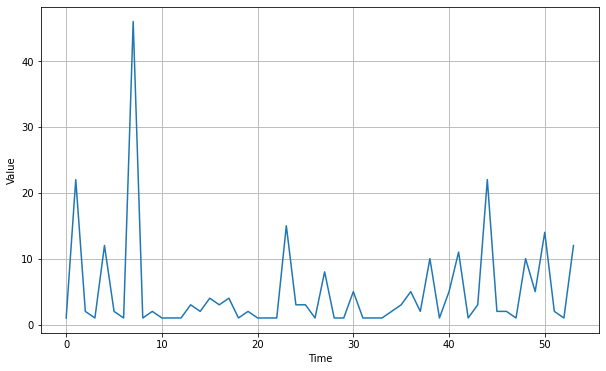

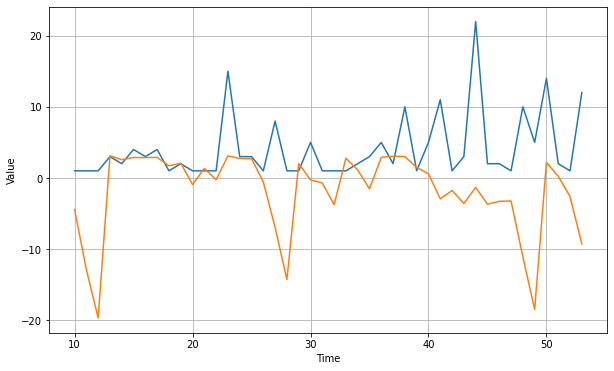

In [53]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 9ms/step - loss: 2.6078 - mae: 3.0528
Epoch 2/300
1/1 [==============================] - 0s 997us/step - loss: 2.6074 - mae: 3.0524
Epoch 3/300
1/1 [==============================] - 0s 997us/step - loss: 2.6067 - mae: 3.0516
Epoch 4/300
1/1 [==============================] - 0s 980us/step - loss: 2.6058 - mae: 3.0504
Epoch 5/300
1/1 [==============================] - 0s 987us/step - loss: 2.6045 - mae: 3.0490
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 2.6030 - mae: 3.0476
Epoch 7/300
1/1 [==============================] - 0s 996us/step - loss: 2.6013 - mae: 3.0460
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 2.5994 - mae: 3.0441
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 2.5974 - mae: 3.0422
Epoch 10/300
1/1 [==============================] - 0s 985us/step - loss: 2.5952 - mae: 3.0400
Epoch 11/300
1/1 [==============================] - 0s 1ms/step - l

1/1 [==============================] - 0s 985us/step - loss: 2.3288 - mae: 2.7523
Epoch 175/300
1/1 [==============================] - 0s 996us/step - loss: 2.3276 - mae: 2.7508
Epoch 176/300
1/1 [==============================] - 0s 1ms/step - loss: 2.3265 - mae: 2.7494
Epoch 177/300
1/1 [==============================] - 0s 996us/step - loss: 2.3253 - mae: 2.7480
Epoch 178/300
1/1 [==============================] - 0s 0s/step - loss: 2.3241 - mae: 2.7465
Epoch 179/300
1/1 [==============================] - 0s 1ms/step - loss: 2.3229 - mae: 2.7451
Epoch 180/300
1/1 [==============================] - 0s 997us/step - loss: 2.3217 - mae: 2.7436
Epoch 181/300
1/1 [==============================] - 0s 2ms/step - loss: 2.3206 - mae: 2.7422
Epoch 182/300
1/1 [==============================] - 0s 980us/step - loss: 2.3194 - mae: 2.7407
Epoch 183/300
1/1 [==============================] - 0s 1ms/step - loss: 2.3182 - mae: 2.7393
Epoch 184/300
1/1 [==============================] - 0s 0s/step -

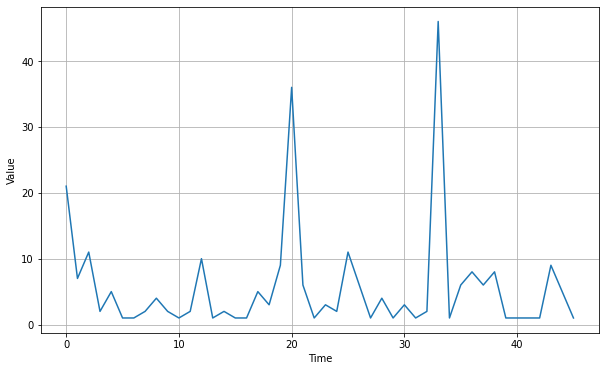

In [54]:
district = 'Jaffna'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

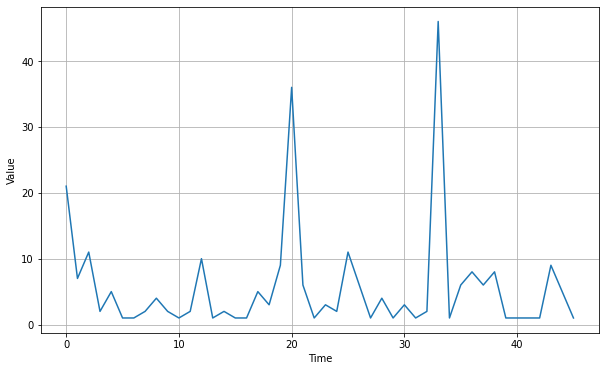

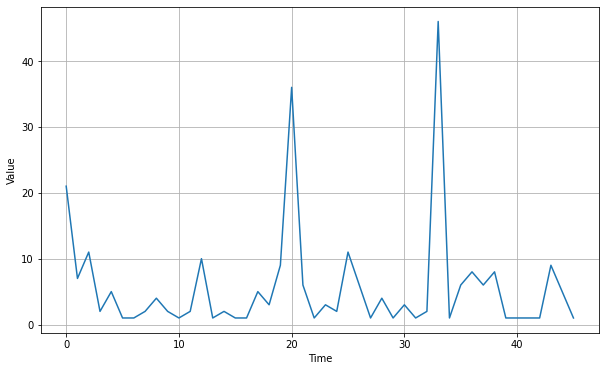

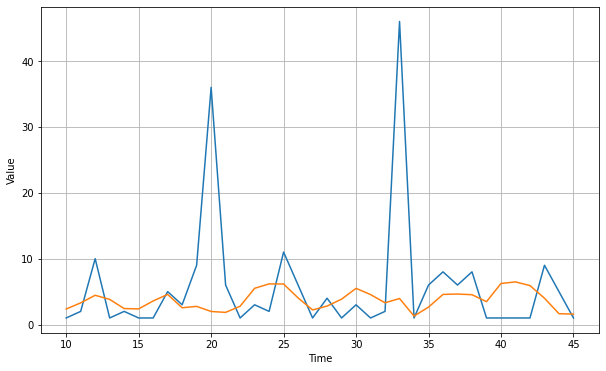

In [55]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 9ms/step - loss: 58.7676 - mae: 59.2676
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 58.7628 - mae: 59.2628
Epoch 3/300
1/1 [==============================] - 0s 998us/step - loss: 58.7537 - mae: 59.2537
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 58.7407 - mae: 59.2407
Epoch 5/300
1/1 [==============================] - 0s 0s/step - loss: 58.7243 - mae: 59.2243
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 58.7046 - mae: 59.2046
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 58.6822 - mae: 59.1822
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 58.6572 - mae: 59.1572
Epoch 9/300
1/1 [==============================] - 0s 1ms/step - loss: 58.6298 - mae: 59.1298
Epoch 10/300
1/1 [==============================] - 0s 997us/step - loss: 58.6004 - mae: 59.1004
Epoch 11/300
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 999us/step - loss: 51.8396 - mae: 52.3389
Epoch 171/300
1/1 [==============================] - 0s 2ms/step - loss: 51.8057 - mae: 52.3047
Epoch 172/300
1/1 [==============================] - 0s 998us/step - loss: 51.7720 - mae: 52.2706
Epoch 173/300
1/1 [==============================] - 0s 991us/step - loss: 51.7385 - mae: 52.2367
Epoch 174/300
1/1 [==============================] - 0s 1ms/step - loss: 51.7051 - mae: 52.2029
Epoch 175/300
1/1 [==============================] - 0s 998us/step - loss: 51.6719 - mae: 52.1692
Epoch 176/300
1/1 [==============================] - 0s 1ms/step - loss: 51.6388 - mae: 52.1356
Epoch 177/300
1/1 [==============================] - 0s 998us/step - loss: 51.6058 - mae: 52.1020
Epoch 178/300
1/1 [==============================] - 0s 997us/step - loss: 51.5729 - mae: 52.0684
Epoch 179/300
1/1 [==============================] - 0s 0s/step - loss: 51.5401 - mae: 52.0350
Epoch 180/300
1/1 [========================

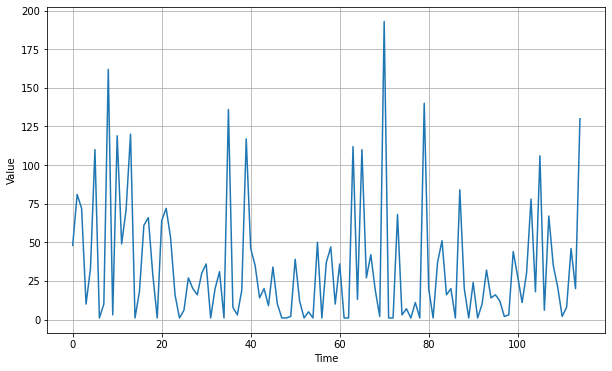

In [56]:
district = 'Kalutara'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

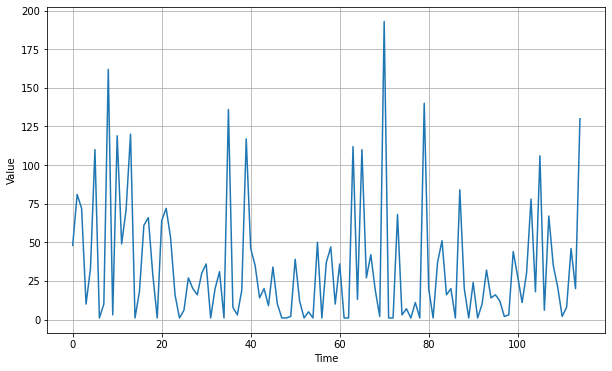

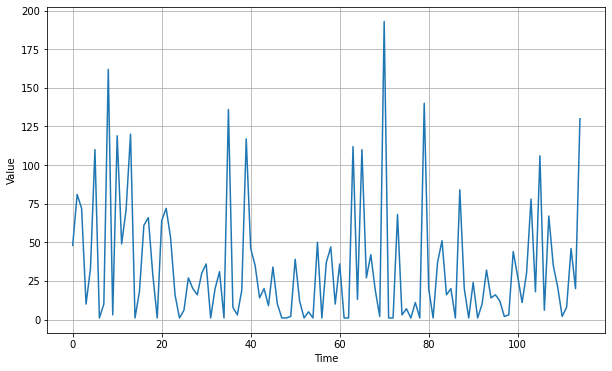

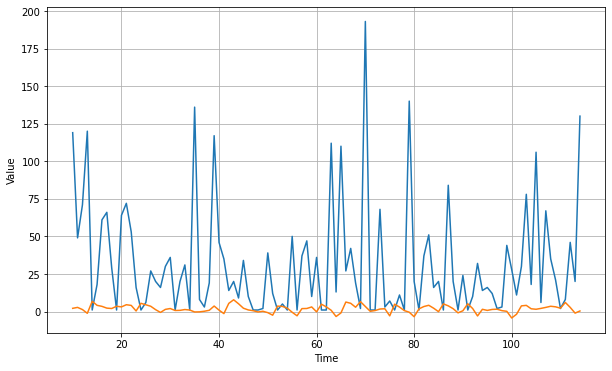

In [57]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 54.8487 - mae: 55.3487
Epoch 2/300
1/1 [==============================] - 0s 998us/step - loss: 54.8457 - mae: 55.3457
Epoch 3/300
1/1 [==============================] - 0s 998us/step - loss: 54.8399 - mae: 55.3399
Epoch 4/300
1/1 [==============================] - 0s 998us/step - loss: 54.8316 - mae: 55.3316
Epoch 5/300
1/1 [==============================] - 0s 996us/step - loss: 54.8211 - mae: 55.3211
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 54.8086 - mae: 55.3086
Epoch 7/300
1/1 [==============================] - 0s 1000us/step - loss: 54.7943 - mae: 55.2943
Epoch 8/300
1/1 [==============================] - 0s 0s/step - loss: 54.7784 - mae: 55.2784
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 54.7610 - mae: 55.2610
Epoch 10/300
1/1 [==============================] - 0s 997us/step - loss: 54.7423 - mae: 55.2423
Epoch 11/300
1/1 [=============================

1/1 [==============================] - 0s 2ms/step - loss: 50.1324 - mae: 50.6324
Epoch 171/300
1/1 [==============================] - 0s 998us/step - loss: 50.1031 - mae: 50.6031
Epoch 172/300
1/1 [==============================] - 0s 2ms/step - loss: 50.0738 - mae: 50.5738
Epoch 173/300
1/1 [==============================] - 0s 997us/step - loss: 50.0445 - mae: 50.5445
Epoch 174/300
1/1 [==============================] - 0s 1ms/step - loss: 50.0152 - mae: 50.5152
Epoch 175/300
1/1 [==============================] - 0s 997us/step - loss: 49.9859 - mae: 50.4859
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 49.9567 - mae: 50.4567
Epoch 177/300
1/1 [==============================] - 0s 998us/step - loss: 49.9274 - mae: 50.4274
Epoch 178/300
1/1 [==============================] - 0s 997us/step - loss: 49.8981 - mae: 50.3981
Epoch 179/300
1/1 [==============================] - 0s 997us/step - loss: 49.8688 - mae: 50.3688
Epoch 180/300
1/1 [=====================

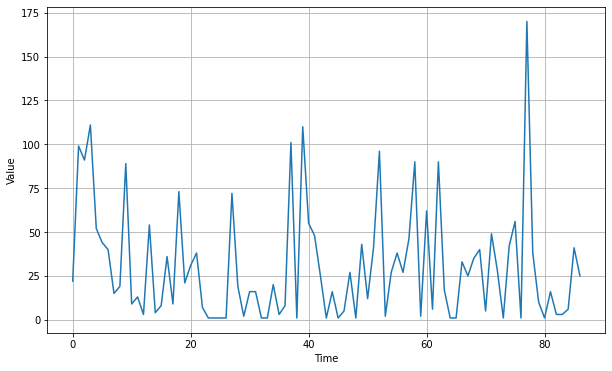

In [59]:
district = 'Kandy'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

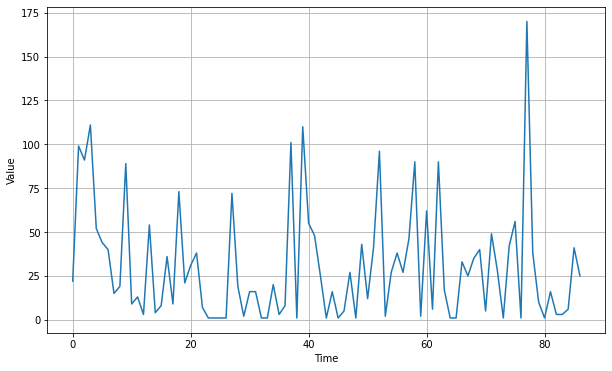

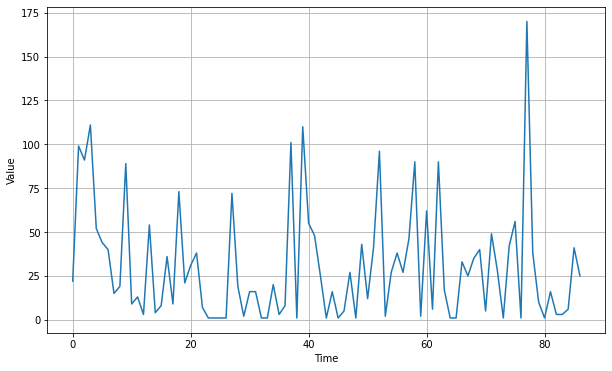

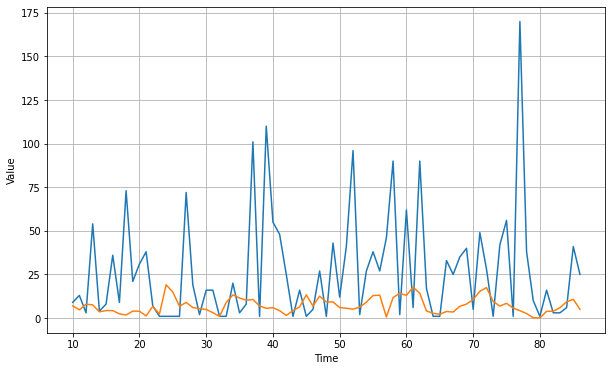

In [60]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 9.3607 - mae: 9.8607
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 9.3567 - mae: 9.8567
Epoch 3/300
1/1 [==============================] - 0s 996us/step - loss: 9.3492 - mae: 9.8492
Epoch 4/300
1/1 [==============================] - 0s 1ms/step - loss: 9.3385 - mae: 9.8385
Epoch 5/300
1/1 [==============================] - 0s 0s/step - loss: 9.3249 - mae: 9.8249
Epoch 6/300
1/1 [==============================] - 0s 1000us/step - loss: 9.3087 - mae: 9.8087
Epoch 7/300
1/1 [==============================] - 0s 0s/step - loss: 9.2903 - mae: 9.7903
Epoch 8/300
1/1 [==============================] - 0s 0s/step - loss: 9.2697 - mae: 9.7697
Epoch 9/300
1/1 [==============================] - 0s 998us/step - loss: 9.2474 - mae: 9.7474
Epoch 10/300
1/1 [==============================] - 0s 997us/step - loss: 9.2233 - mae: 9.7233
Epoch 11/300
1/1 [==============================] - 0s 990us/step - loss:

1/1 [==============================] - 0s 998us/step - loss: 5.3883 - mae: 5.8593
Epoch 175/300
1/1 [==============================] - 0s 1ms/step - loss: 5.3767 - mae: 5.8478
Epoch 176/300
1/1 [==============================] - 0s 1ms/step - loss: 5.3650 - mae: 5.8363
Epoch 177/300
1/1 [==============================] - 0s 996us/step - loss: 5.3533 - mae: 5.8246
Epoch 178/300
1/1 [==============================] - 0s 0s/step - loss: 5.3416 - mae: 5.8130
Epoch 179/300
1/1 [==============================] - 0s 1ms/step - loss: 5.3300 - mae: 5.8015
Epoch 180/300
1/1 [==============================] - 0s 994us/step - loss: 5.3184 - mae: 5.7899
Epoch 181/300
1/1 [==============================] - 0s 996us/step - loss: 5.3069 - mae: 5.7784
Epoch 182/300
1/1 [==============================] - 0s 993us/step - loss: 5.2956 - mae: 5.7670
Epoch 183/300
1/1 [==============================] - 0s 997us/step - loss: 5.2845 - mae: 5.7558
Epoch 184/300
1/1 [==============================] - 0s 998us/s

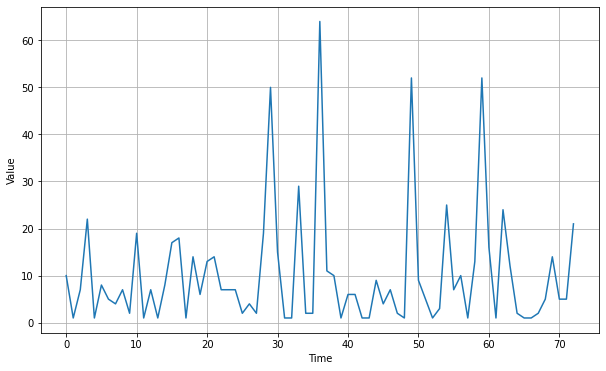

In [62]:
district = 'Kegalle'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

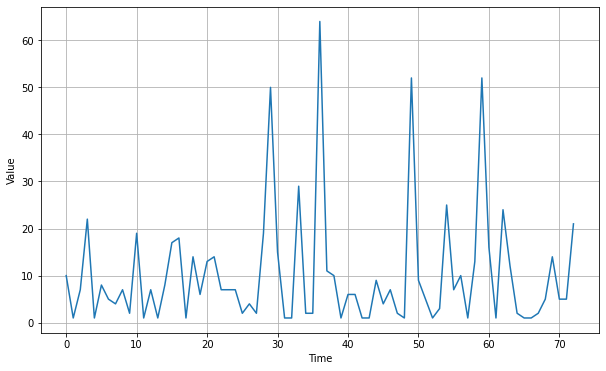

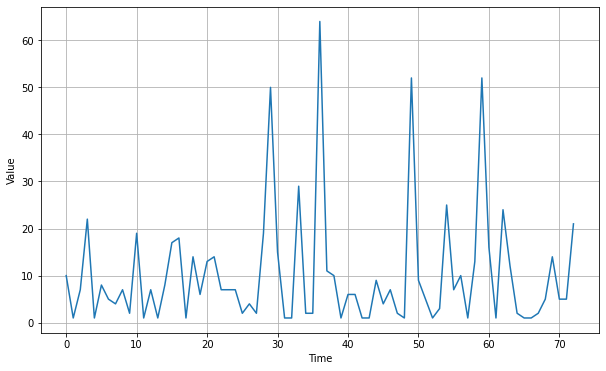

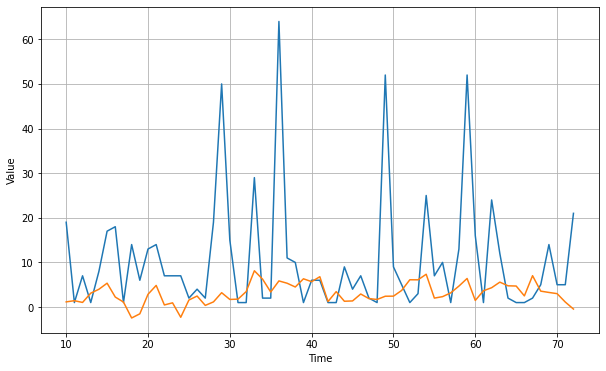

In [63]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 3.9724 - mae: 4.4724
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 3.9690 - mae: 4.4690
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 3.9627 - mae: 4.4627
Epoch 4/300
1/1 [==============================] - 0s 994us/step - loss: 3.9536 - mae: 4.4536
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 3.9421 - mae: 4.4421
Epoch 6/300
1/1 [==============================] - 0s 997us/step - loss: 3.9285 - mae: 4.4285
Epoch 7/300
1/1 [==============================] - 0s 999us/step - loss: 3.9128 - mae: 4.4128
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 3.8951 - mae: 4.3951
Epoch 9/300
1/1 [==============================] - 0s 997us/step - loss: 3.8753 - mae: 4.3751
Epoch 10/300
1/1 [==============================] - 0s 0s/step - loss: 3.8535 - mae: 4.3532
Epoch 11/300
1/1 [==============================] - 0s 996us/step - loss

1/1 [==============================] - 0s 1ms/step - loss: 2.0812 - mae: 2.5426
Epoch 175/300
1/1 [==============================] - 0s 2ms/step - loss: 2.0810 - mae: 2.5425
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 2.0807 - mae: 2.5423
Epoch 177/300
1/1 [==============================] - 0s 996us/step - loss: 2.0805 - mae: 2.5421
Epoch 178/300
1/1 [==============================] - 0s 996us/step - loss: 2.0803 - mae: 2.5419
Epoch 179/300
1/1 [==============================] - 0s 996us/step - loss: 2.0801 - mae: 2.5417
Epoch 180/300
1/1 [==============================] - 0s 997us/step - loss: 2.0798 - mae: 2.5416
Epoch 181/300
1/1 [==============================] - 0s 1ms/step - loss: 2.0796 - mae: 2.5414
Epoch 182/300
1/1 [==============================] - 0s 998us/step - loss: 2.0794 - mae: 2.5412
Epoch 183/300
1/1 [==============================] - 0s 997us/step - loss: 2.0791 - mae: 2.5410
Epoch 184/300
1/1 [==============================] - 0s 0s/s

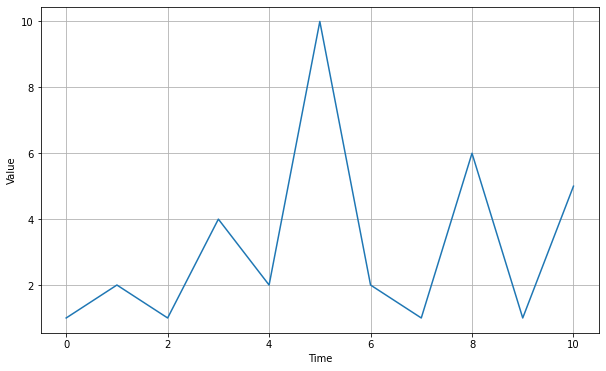

In [64]:
district = 'Kilinochchi'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

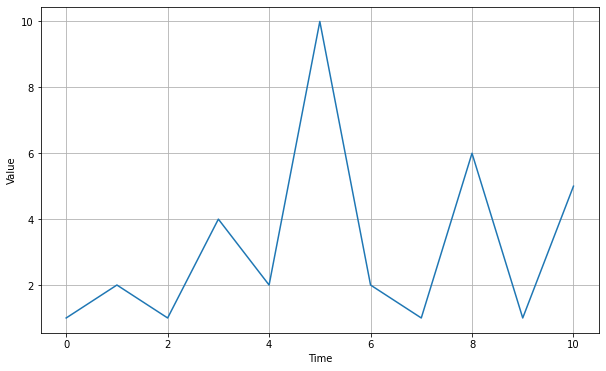

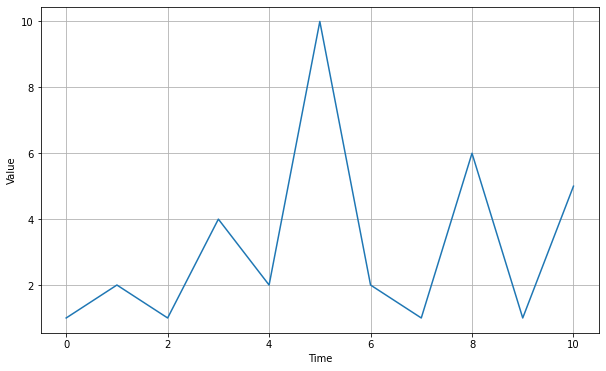

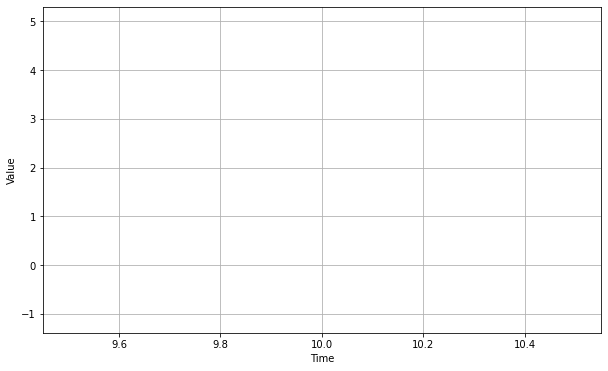

In [65]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 16.4135 - mae: 16.9135
Epoch 2/300
1/1 [==============================] - 0s 999us/step - loss: 16.4084 - mae: 16.9084
Epoch 3/300
1/1 [==============================] - 0s 0s/step - loss: 16.3988 - mae: 16.8988
Epoch 4/300
1/1 [==============================] - 0s 995us/step - loss: 16.3851 - mae: 16.8851
Epoch 5/300
1/1 [==============================] - 0s 998us/step - loss: 16.3677 - mae: 16.8677
Epoch 6/300
1/1 [==============================] - 0s 997us/step - loss: 16.3469 - mae: 16.8469
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 16.3232 - mae: 16.8232
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 16.2968 - mae: 16.7968
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 16.2682 - mae: 16.7682
Epoch 10/300
1/1 [==============================] - 0s 998us/step - loss: 16.2377 - mae: 16.7377
Epoch 11/300
1/1 [==============================] 

1/1 [==============================] - 0s 1ms/step - loss: 10.5053 - mae: 11.0053
Epoch 171/300
1/1 [==============================] - 0s 997us/step - loss: 10.4766 - mae: 10.9766
Epoch 172/300
1/1 [==============================] - 0s 2ms/step - loss: 10.4480 - mae: 10.9480
Epoch 173/300
1/1 [==============================] - 0s 2ms/step - loss: 10.4193 - mae: 10.9193
Epoch 174/300
1/1 [==============================] - 0s 990us/step - loss: 10.3907 - mae: 10.8907
Epoch 175/300
1/1 [==============================] - 0s 1ms/step - loss: 10.3621 - mae: 10.8621
Epoch 176/300
1/1 [==============================] - 0s 1ms/step - loss: 10.3335 - mae: 10.8335
Epoch 177/300
1/1 [==============================] - 0s 997us/step - loss: 10.3049 - mae: 10.8049
Epoch 178/300
1/1 [==============================] - 0s 999us/step - loss: 10.2764 - mae: 10.7764
Epoch 179/300
1/1 [==============================] - 0s 998us/step - loss: 10.2482 - mae: 10.7482
Epoch 180/300
1/1 [=========================

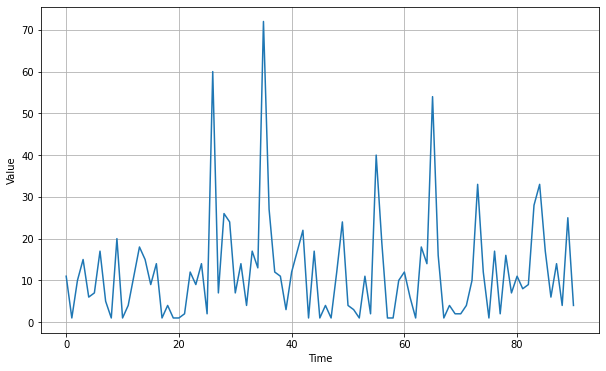

In [66]:
district = 'Kurunegala'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

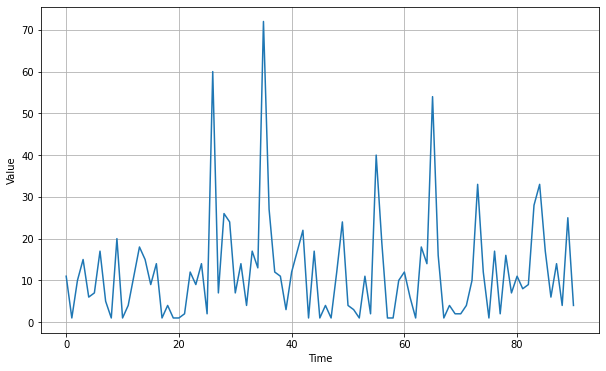

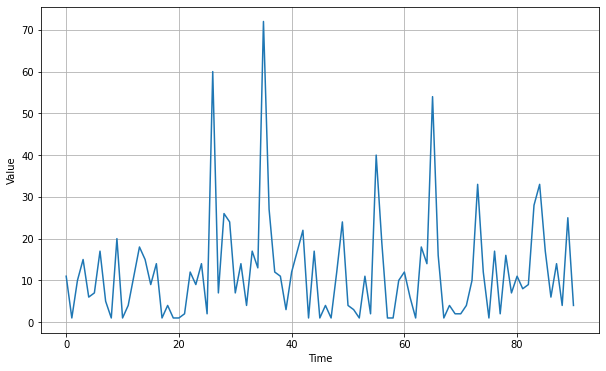

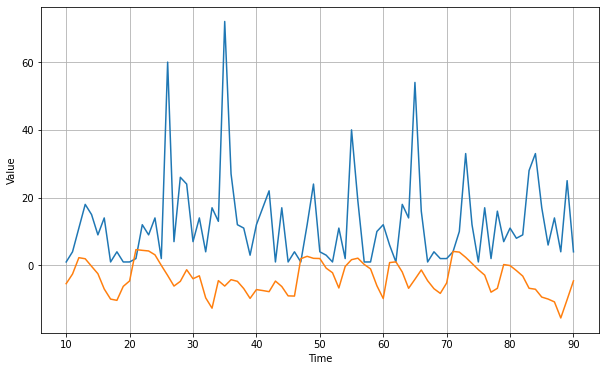

In [67]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 9ms/step - loss: 4.3644 - mae: 4.8401
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 4.3641 - mae: 4.8399
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 4.3636 - mae: 4.8393
Epoch 4/300
1/1 [==============================] - 0s 998us/step - loss: 4.3628 - mae: 4.8386
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 4.3618 - mae: 4.8377
Epoch 6/300
1/1 [==============================] - 0s 987us/step - loss: 4.3606 - mae: 4.8365
Epoch 7/300
1/1 [==============================] - 0s 0s/step - loss: 4.3592 - mae: 4.8353
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 4.3576 - mae: 4.8338
Epoch 9/300
1/1 [==============================] - 0s 998us/step - loss: 4.3560 - mae: 4.8323
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 4.3542 - mae: 4.8306
Epoch 11/300
1/1 [==============================] - 0s 998us/step - loss: 

1/1 [==============================] - 0s 997us/step - loss: 4.2096 - mae: 4.6692
Epoch 89/300
1/1 [==============================] - 0s 993us/step - loss: 4.2082 - mae: 4.6678
Epoch 90/300
1/1 [==============================] - 0s 997us/step - loss: 4.2068 - mae: 4.6665
Epoch 91/300
1/1 [==============================] - 0s 1ms/step - loss: 4.2054 - mae: 4.6651
Epoch 92/300
1/1 [==============================] - 0s 1ms/step - loss: 4.2040 - mae: 4.6638
Epoch 93/300
1/1 [==============================] - 0s 996us/step - loss: 4.2027 - mae: 4.6624
Epoch 94/300
1/1 [==============================] - 0s 997us/step - loss: 4.2013 - mae: 4.6611
Epoch 95/300
1/1 [==============================] - 0s 1ms/step - loss: 4.2000 - mae: 4.6603
Epoch 96/300
1/1 [==============================] - 0s 998us/step - loss: 4.1987 - mae: 4.6595
Epoch 97/300
1/1 [==============================] - 0s 997us/step - loss: 4.1973 - mae: 4.6587
Epoch 98/300
1/1 [==============================] - 0s 1ms/step - los

1/1 [==============================] - 0s 0s/step - loss: 4.0500 - mae: 4.5215
Epoch 261/300
1/1 [==============================] - 0s 2ms/step - loss: 4.0492 - mae: 4.5205
Epoch 262/300
1/1 [==============================] - 0s 998us/step - loss: 4.0485 - mae: 4.5196
Epoch 263/300
1/1 [==============================] - 0s 998us/step - loss: 4.0477 - mae: 4.5187
Epoch 264/300
1/1 [==============================] - 0s 0s/step - loss: 4.0470 - mae: 4.5178
Epoch 265/300
1/1 [==============================] - 0s 998us/step - loss: 4.0463 - mae: 4.5169
Epoch 266/300
1/1 [==============================] - 0s 1ms/step - loss: 4.0455 - mae: 4.5159
Epoch 267/300
1/1 [==============================] - 0s 2ms/step - loss: 4.0448 - mae: 4.5150
Epoch 268/300
1/1 [==============================] - 0s 1ms/step - loss: 4.0441 - mae: 4.5141
Epoch 269/300
1/1 [==============================] - 0s 0s/step - loss: 4.0433 - mae: 4.5132
Epoch 270/300
1/1 [==============================] - 0s 997us/step - lo

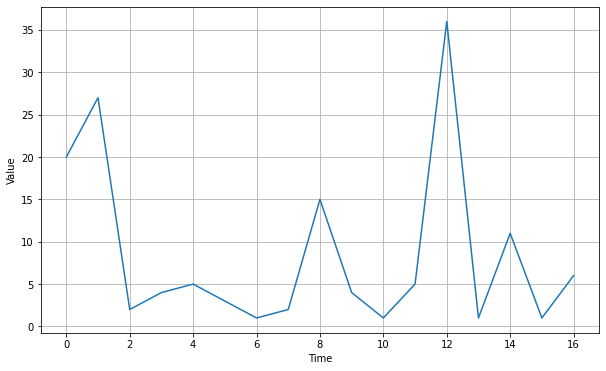

In [68]:
district = 'Mannar'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

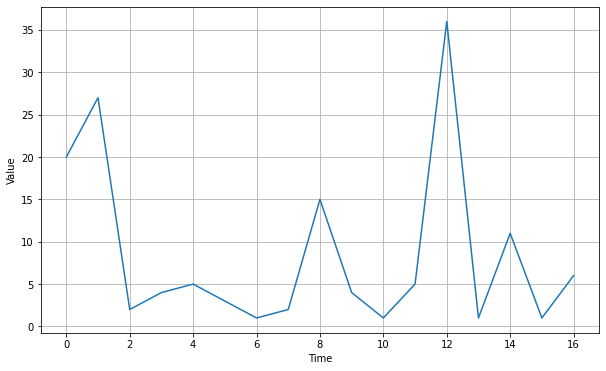

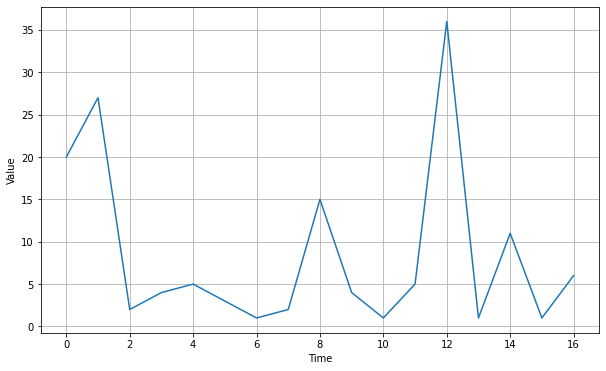

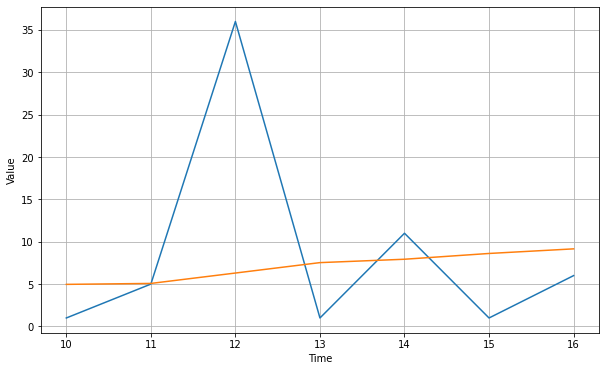

In [69]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 8.6603 - mae: 9.1603
Epoch 2/300
1/1 [==============================] - 0s 999us/step - loss: 8.6539 - mae: 9.1539
Epoch 3/300
1/1 [==============================] - 0s 997us/step - loss: 8.6416 - mae: 9.1416
Epoch 4/300
1/1 [==============================] - 0s 998us/step - loss: 8.6241 - mae: 9.1241
Epoch 5/300
1/1 [==============================] - 0s 998us/step - loss: 8.6018 - mae: 9.1018
Epoch 6/300
1/1 [==============================] - 0s 0s/step - loss: 8.5754 - mae: 9.0754
Epoch 7/300
1/1 [==============================] - 0s 0s/step - loss: 8.5456 - mae: 9.0456
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 8.5133 - mae: 9.0133
Epoch 9/300
1/1 [==============================] - 0s 996us/step - loss: 8.4794 - mae: 8.9794
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 8.4435 - mae: 8.9435
Epoch 11/300
1/1 [==============================] - 0s 995us/step - los

1/1 [==============================] - 0s 2ms/step - loss: 4.3302 - mae: 4.7930
Epoch 175/300
1/1 [==============================] - 0s 2ms/step - loss: 4.3179 - mae: 4.7810
Epoch 176/300
1/1 [==============================] - 0s 1ms/step - loss: 4.3057 - mae: 4.7690
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 4.2935 - mae: 4.7571
Epoch 178/300
1/1 [==============================] - 0s 998us/step - loss: 4.2814 - mae: 4.7452
Epoch 179/300
1/1 [==============================] - 0s 1ms/step - loss: 4.2694 - mae: 4.7334
Epoch 180/300
1/1 [==============================] - 0s 2ms/step - loss: 4.2575 - mae: 4.7224
Epoch 181/300
1/1 [==============================] - 0s 1ms/step - loss: 4.2456 - mae: 4.7118
Epoch 182/300
1/1 [==============================] - 0s 995us/step - loss: 4.2338 - mae: 4.7013
Epoch 183/300
1/1 [==============================] - 0s 998us/step - loss: 4.2220 - mae: 4.6907
Epoch 184/300
1/1 [==============================] - 0s 996us/step -

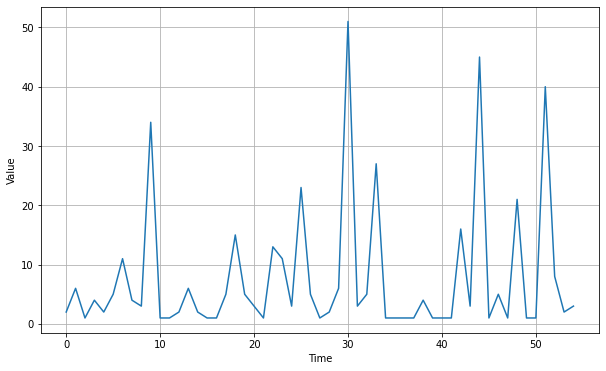

In [70]:
district = 'Matale'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

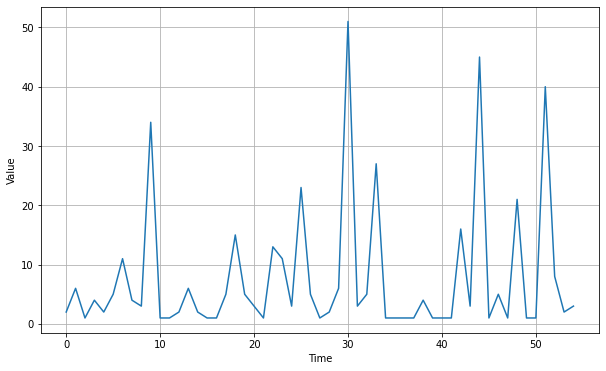

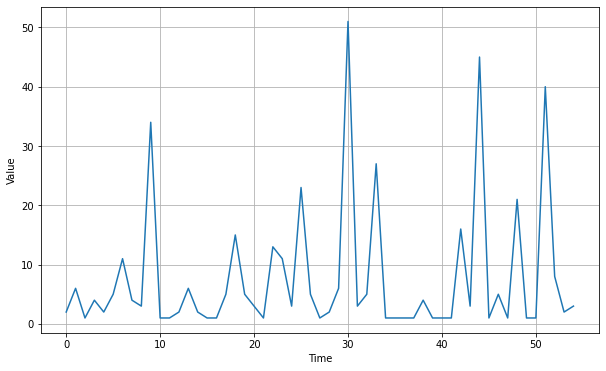

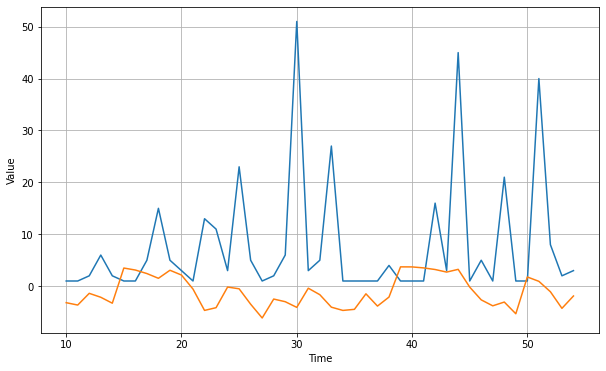

In [71]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 9.3807 - mae: 9.8807
Epoch 2/300
1/1 [==============================] - 0s 996us/step - loss: 9.3777 - mae: 9.8777
Epoch 3/300
1/1 [==============================] - 0s 997us/step - loss: 9.3720 - mae: 9.8720
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 9.3640 - mae: 9.8640
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 9.3537 - mae: 9.8537
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 9.3415 - mae: 9.8415
Epoch 7/300
1/1 [==============================] - 0s 0s/step - loss: 9.3276 - mae: 9.8276
Epoch 8/300
1/1 [==============================] - 0s 998us/step - loss: 9.3121 - mae: 9.8120
Epoch 9/300
1/1 [==============================] - 0s 997us/step - loss: 9.2951 - mae: 9.7950
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 9.2769 - mae: 9.7768
Epoch 11/300
1/1 [==============================] - 0s 996us/step - loss

1/1 [==============================] - 0s 2ms/step - loss: 6.3961 - mae: 6.8795
Epoch 175/300
1/1 [==============================] - 0s 998us/step - loss: 6.3894 - mae: 6.8735
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 6.3828 - mae: 6.8675
Epoch 177/300
1/1 [==============================] - 0s 997us/step - loss: 6.3763 - mae: 6.8615
Epoch 178/300
1/1 [==============================] - 0s 1ms/step - loss: 6.3699 - mae: 6.8556
Epoch 179/300
1/1 [==============================] - 0s 998us/step - loss: 6.3636 - mae: 6.8497
Epoch 180/300
1/1 [==============================] - 0s 2ms/step - loss: 6.3574 - mae: 6.8439
Epoch 181/300
1/1 [==============================] - 0s 998us/step - loss: 6.3513 - mae: 6.8381
Epoch 182/300
1/1 [==============================] - 0s 1ms/step - loss: 6.3453 - mae: 6.8324
Epoch 183/300
1/1 [==============================] - 0s 1ms/step - loss: 6.3394 - mae: 6.8267
Epoch 184/300
1/1 [==============================] - 0s 998us/st

1/1 [==============================] - 0s 1ms/step - loss: 6.0379 - mae: 6.5159
Epoch 261/300
1/1 [==============================] - 0s 994us/step - loss: 6.0351 - mae: 6.5136
Epoch 262/300
1/1 [==============================] - 0s 997us/step - loss: 6.0322 - mae: 6.5112
Epoch 263/300
1/1 [==============================] - 0s 997us/step - loss: 6.0293 - mae: 6.5089
Epoch 264/300
1/1 [==============================] - 0s 997us/step - loss: 6.0265 - mae: 6.5066
Epoch 265/300
1/1 [==============================] - 0s 2ms/step - loss: 6.0236 - mae: 6.5043
Epoch 266/300
1/1 [==============================] - 0s 3ms/step - loss: 6.0208 - mae: 6.5020
Epoch 267/300
1/1 [==============================] - 0s 997us/step - loss: 6.0180 - mae: 6.4998
Epoch 268/300
1/1 [==============================] - 0s 2ms/step - loss: 6.0152 - mae: 6.4975
Epoch 269/300
1/1 [==============================] - 0s 996us/step - loss: 6.0124 - mae: 6.4951
Epoch 270/300
1/1 [==============================] - 0s 997us/

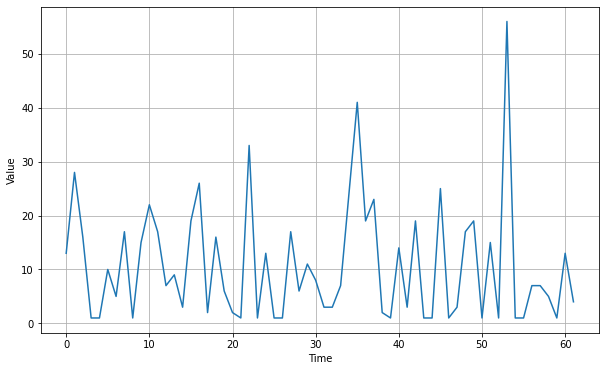

In [72]:
district = 'Matara'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

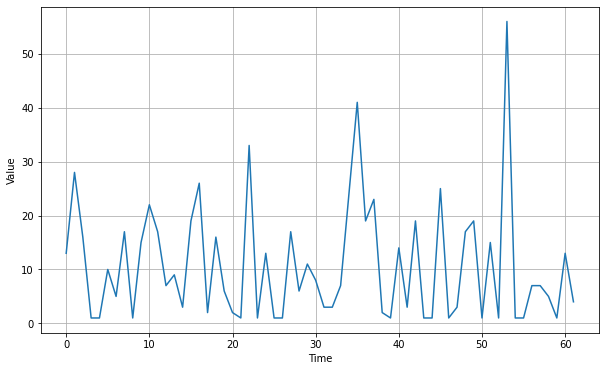

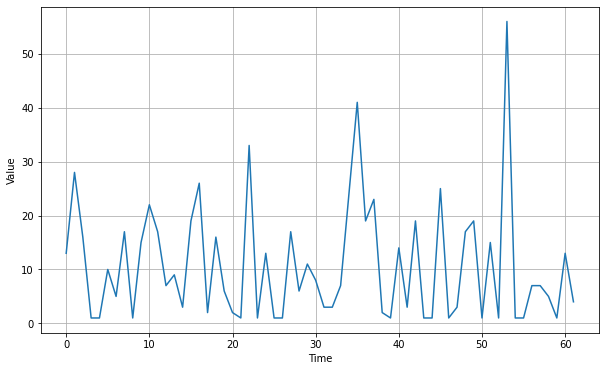

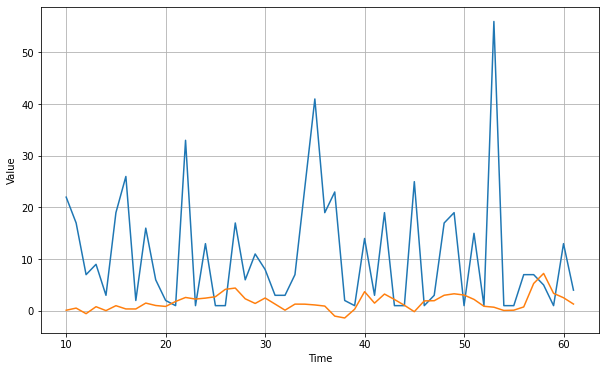

In [73]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 9.8253 - mae: 10.3253
Epoch 2/300
1/1 [==============================] - 0s 0s/step - loss: 9.8177 - mae: 10.3177
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 9.8035 - mae: 10.3035
Epoch 4/300
1/1 [==============================] - 0s 997us/step - loss: 9.7833 - mae: 10.2833
Epoch 5/300
1/1 [==============================] - 0s 999us/step - loss: 9.7582 - mae: 10.2582
Epoch 6/300
1/1 [==============================] - 0s 998us/step - loss: 9.7286 - mae: 10.2286
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 9.6954 - mae: 10.1953
Epoch 8/300
1/1 [==============================] - 0s 998us/step - loss: 9.6588 - mae: 10.1585
Epoch 9/300
1/1 [==============================] - 0s 996us/step - loss: 9.6191 - mae: 10.1186
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 9.5773 - mae: 10.0764
Epoch 11/300
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 999us/step - loss: 5.3406 - mae: 5.8141
Epoch 175/300
1/1 [==============================] - 0s 999us/step - loss: 5.3327 - mae: 5.8062
Epoch 176/300
1/1 [==============================] - 0s 998us/step - loss: 5.3247 - mae: 5.7983
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 5.3169 - mae: 5.7904
Epoch 178/300
1/1 [==============================] - 0s 1ms/step - loss: 5.3090 - mae: 5.7825
Epoch 179/300
1/1 [==============================] - 0s 999us/step - loss: 5.3011 - mae: 5.7746
Epoch 180/300
1/1 [==============================] - 0s 997us/step - loss: 5.2933 - mae: 5.7667
Epoch 181/300
1/1 [==============================] - 0s 1ms/step - loss: 5.2854 - mae: 5.7589
Epoch 182/300
1/1 [==============================] - 0s 0s/step - loss: 5.2776 - mae: 5.7510
Epoch 183/300
1/1 [==============================] - 0s 998us/step - loss: 5.2699 - mae: 5.7432
Epoch 184/300
1/1 [==============================] - 0s 993us/s

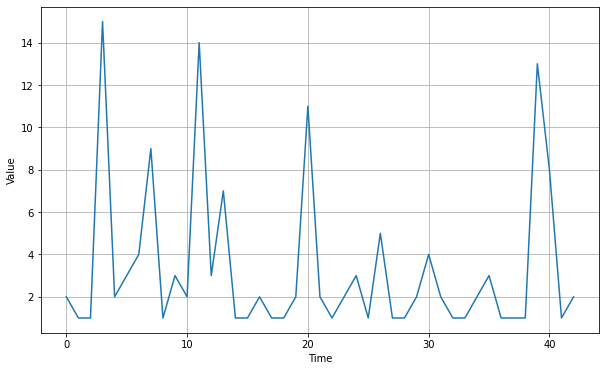

In [74]:
district = 'Moneragala'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district)

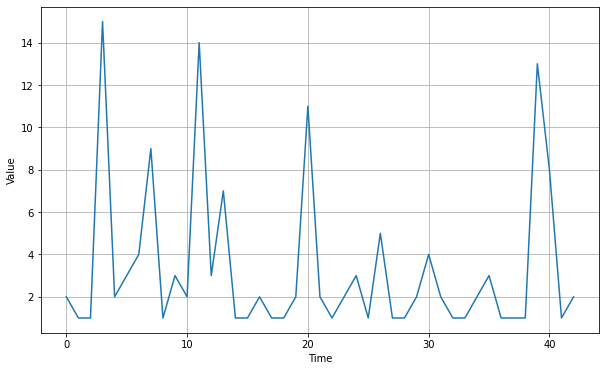

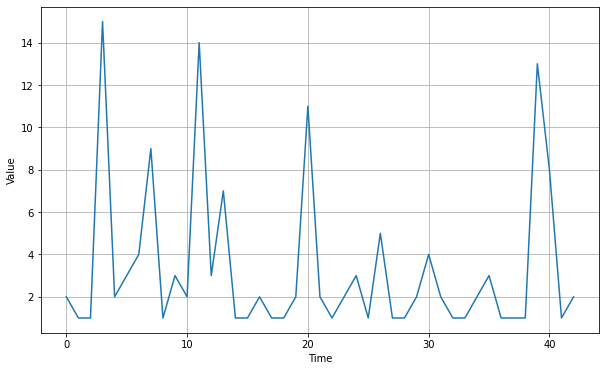

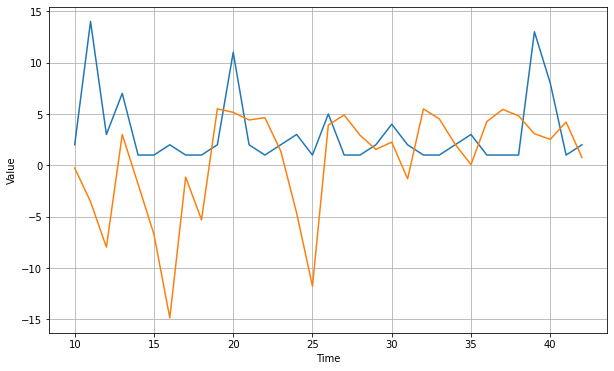

In [75]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 10.9175 - mae: 11.4154
Epoch 2/300
1/1 [==============================] - 0s 997us/step - loss: 10.9150 - mae: 11.4129
Epoch 3/300
1/1 [==============================] - 0s 3ms/step - loss: 10.9103 - mae: 11.4081
Epoch 4/300
1/1 [==============================] - 0s 998us/step - loss: 10.9037 - mae: 11.4013
Epoch 5/300
1/1 [==============================] - 0s 997us/step - loss: 10.8952 - mae: 11.3926
Epoch 6/300
1/1 [==============================] - 0s 996us/step - loss: 10.8851 - mae: 11.3822
Epoch 7/300
1/1 [==============================] - 0s 997us/step - loss: 10.8737 - mae: 11.3704
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 10.8610 - mae: 11.3573
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 10.8471 - mae: 11.3429
Epoch 10/300
1/1 [==============================] - 0s 997us/step - loss: 10.8323 - mae: 11.3275
Epoch 11/300
1/1 [=============================

1/1 [==============================] - 0s 1ms/step - loss: 9.6863 - mae: 10.1443
Epoch 172/300
1/1 [==============================] - 0s 998us/step - loss: 9.6835 - mae: 10.1418
Epoch 173/300
1/1 [==============================] - 0s 980us/step - loss: 9.6808 - mae: 10.1393
Epoch 174/300
1/1 [==============================] - 0s 996us/step - loss: 9.6781 - mae: 10.1368
Epoch 175/300
1/1 [==============================] - 0s 998us/step - loss: 9.6753 - mae: 10.1343
Epoch 176/300
1/1 [==============================] - 0s 2ms/step - loss: 9.6726 - mae: 10.1317
Epoch 177/300
1/1 [==============================] - 0s 2ms/step - loss: 9.6699 - mae: 10.1292
Epoch 178/300
1/1 [==============================] - 0s 997us/step - loss: 9.6672 - mae: 10.1267
Epoch 179/300
1/1 [==============================] - 0s 1ms/step - loss: 9.6644 - mae: 10.1242
Epoch 180/300
1/1 [==============================] - 0s 998us/step - loss: 9.6617 - mae: 10.1217
Epoch 181/300
1/1 [==============================] -

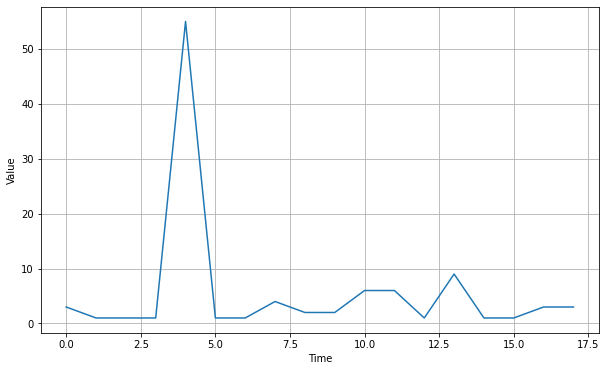

In [76]:
district = 'Mullaitivu'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district) 

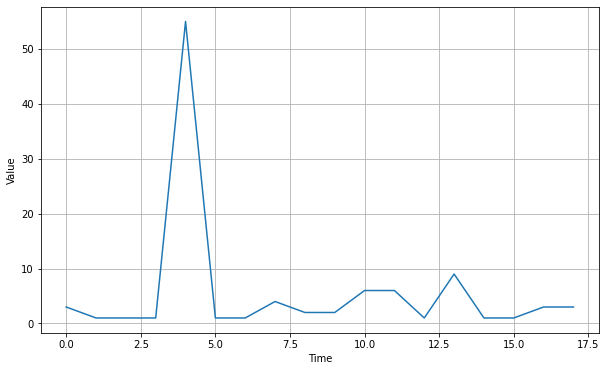

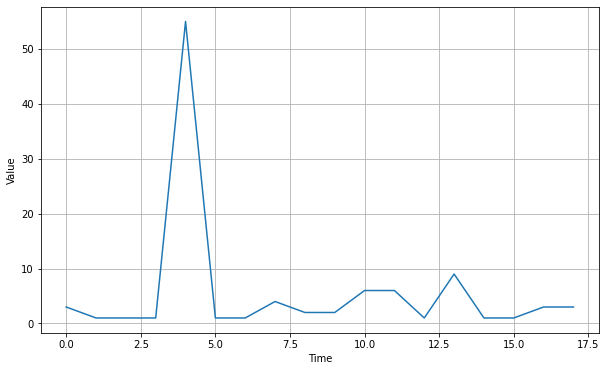

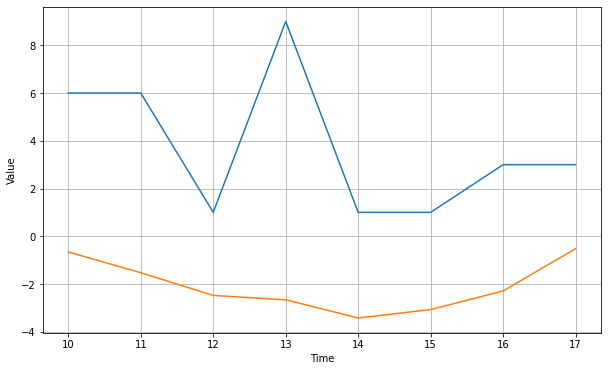

In [77]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 7.7230 - mae: 8.2230
Epoch 2/300
1/1 [==============================] - 0s 984us/step - loss: 7.7162 - mae: 8.2162
Epoch 3/300
1/1 [==============================] - 0s 985us/step - loss: 7.7032 - mae: 8.2032
Epoch 4/300
1/1 [==============================] - 0s 1ms/step - loss: 7.6848 - mae: 8.1848
Epoch 5/300
1/1 [==============================] - 0s 996us/step - loss: 7.6614 - mae: 8.1614
Epoch 6/300
1/1 [==============================] - 0s 995us/step - loss: 7.6334 - mae: 8.1334
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 7.6015 - mae: 8.1015
Epoch 8/300
1/1 [==============================] - 0s 988us/step - loss: 7.5661 - mae: 8.0661
Epoch 9/300
1/1 [==============================] - 0s 0s/step - loss: 7.5278 - mae: 8.0278
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 7.4868 - mae: 7.9868
Epoch 11/300
1/1 [==============================] - 0s 2ms/step - loss

1/1 [==============================] - 0s 998us/step - loss: 3.8155 - mae: 4.2988
Epoch 175/300
1/1 [==============================] - 0s 1ms/step - loss: 3.8083 - mae: 4.2905
Epoch 176/300
1/1 [==============================] - 0s 2ms/step - loss: 3.8013 - mae: 4.2822
Epoch 177/300
1/1 [==============================] - 0s 997us/step - loss: 3.7943 - mae: 4.2740
Epoch 178/300
1/1 [==============================] - 0s 985us/step - loss: 3.7874 - mae: 4.2658
Epoch 179/300
1/1 [==============================] - 0s 998us/step - loss: 3.7806 - mae: 4.2577
Epoch 180/300
1/1 [==============================] - 0s 982us/step - loss: 3.7739 - mae: 4.2497
Epoch 181/300
1/1 [==============================] - 0s 999us/step - loss: 3.7673 - mae: 4.2417
Epoch 182/300
1/1 [==============================] - 0s 1ms/step - loss: 3.7608 - mae: 4.2337
Epoch 183/300
1/1 [==============================] - 0s 998us/step - loss: 3.7544 - mae: 4.2258
Epoch 184/300
1/1 [==============================] - 0s 997u

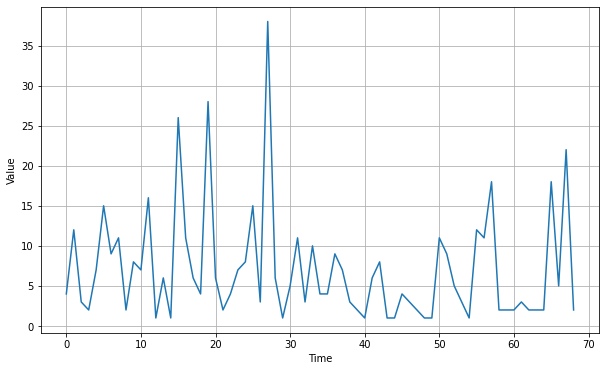

In [78]:
district = 'Nuwara Eliya'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district) 

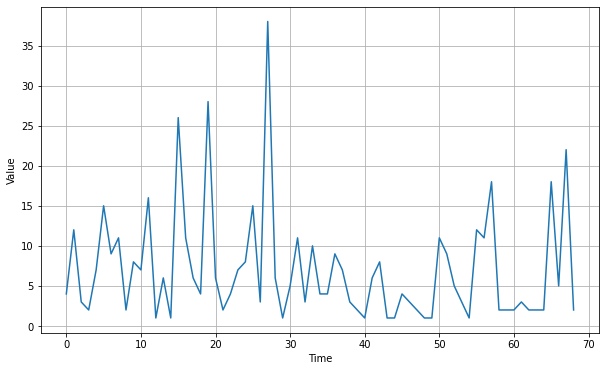

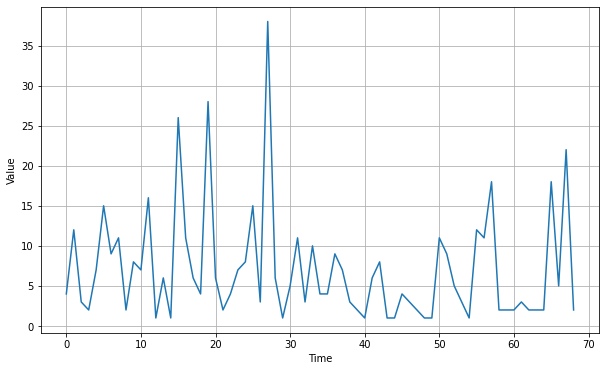

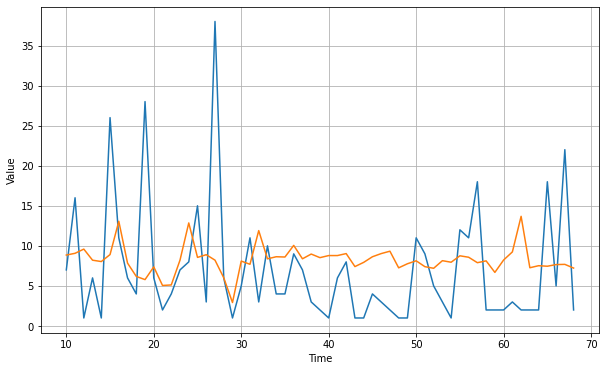

In [79]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 3.3259 - mae: 3.8259
Epoch 2/300
1/1 [==============================] - 0s 1000us/step - loss: 3.3223 - mae: 3.8223
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 3.3155 - mae: 3.8155
Epoch 4/300
1/1 [==============================] - 0s 998us/step - loss: 3.3058 - mae: 3.8058
Epoch 5/300
1/1 [==============================] - 0s 998us/step - loss: 3.2935 - mae: 3.7935
Epoch 6/300
1/1 [==============================] - 0s 998us/step - loss: 3.2789 - mae: 3.7789
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 3.2623 - mae: 3.7622
Epoch 8/300
1/1 [==============================] - 0s 988us/step - loss: 3.2437 - mae: 3.7436
Epoch 9/300
1/1 [==============================] - 0s 983us/step - loss: 3.2235 - mae: 3.7234
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 3.2019 - mae: 3.7016
Epoch 11/300
1/1 [==============================] - 0s 999us/step 

1/1 [==============================] - 0s 997us/step - loss: 1.7428 - mae: 2.1946
Epoch 89/300
1/1 [==============================] - 0s 0s/step - loss: 1.7370 - mae: 2.1896
Epoch 90/300
1/1 [==============================] - 0s 2ms/step - loss: 1.7314 - mae: 2.1848
Epoch 91/300
1/1 [==============================] - 0s 989us/step - loss: 1.7259 - mae: 2.1800
Epoch 92/300
1/1 [==============================] - 0s 1ms/step - loss: 1.7206 - mae: 2.1753
Epoch 93/300
1/1 [==============================] - 0s 0s/step - loss: 1.7155 - mae: 2.1706
Epoch 94/300
1/1 [==============================] - 0s 998us/step - loss: 1.7105 - mae: 2.1661
Epoch 95/300
1/1 [==============================] - 0s 998us/step - loss: 1.7057 - mae: 2.1616
Epoch 96/300
1/1 [==============================] - 0s 1ms/step - loss: 1.7010 - mae: 2.1572
Epoch 97/300
1/1 [==============================] - 0s 982us/step - loss: 1.6965 - mae: 2.1528
Epoch 98/300
1/1 [==============================] - 0s 0s/step - loss: 1.69

1/1 [==============================] - 0s 981us/step - loss: 1.4017 - mae: 1.8896
Epoch 261/300
1/1 [==============================] - 0s 937us/step - loss: 1.4006 - mae: 1.8885
Epoch 262/300
1/1 [==============================] - 0s 0s/step - loss: 1.3995 - mae: 1.8873
Epoch 263/300
1/1 [==============================] - 0s 975us/step - loss: 1.3984 - mae: 1.8861
Epoch 264/300
1/1 [==============================] - 0s 998us/step - loss: 1.3973 - mae: 1.8850
Epoch 265/300
1/1 [==============================] - 0s 998us/step - loss: 1.3962 - mae: 1.8838
Epoch 266/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3951 - mae: 1.8827
Epoch 267/300
1/1 [==============================] - 0s 0s/step - loss: 1.3940 - mae: 1.8815
Epoch 268/300
1/1 [==============================] - 0s 997us/step - loss: 1.3929 - mae: 1.8804
Epoch 269/300
1/1 [==============================] - 0s 998us/step - loss: 1.3918 - mae: 1.8792
Epoch 270/300
1/1 [==============================] - 0s 0s/ste

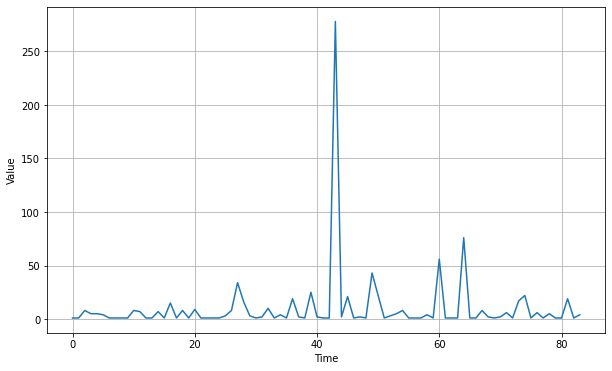

In [80]:
district = 'Polonnaruwa'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district) 

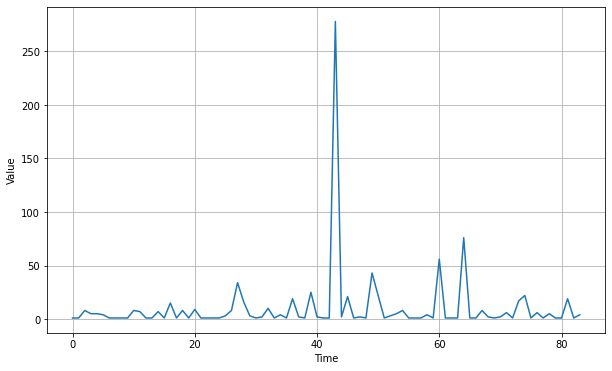

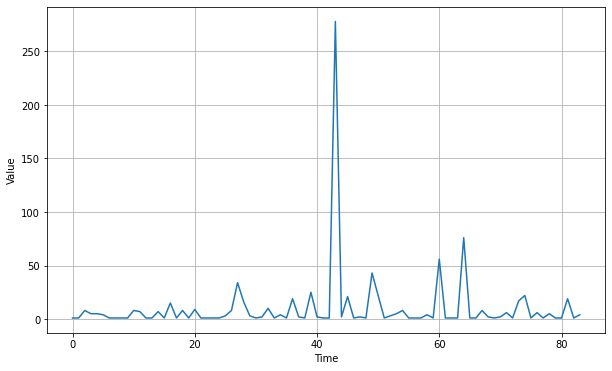

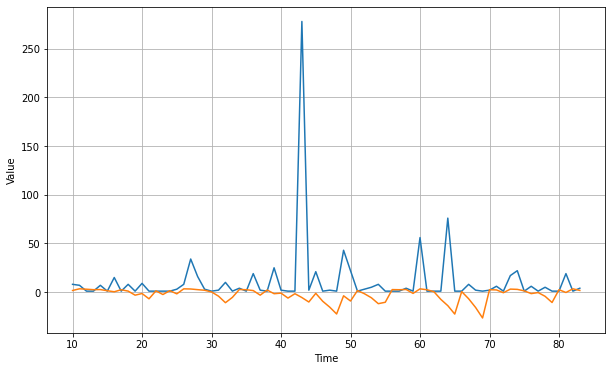

In [81]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 9.4311 - mae: 9.9311
Epoch 2/300
1/1 [==============================] - 0s 986us/step - loss: 9.4275 - mae: 9.9275
Epoch 3/300
1/1 [==============================] - 0s 986us/step - loss: 9.4208 - mae: 9.9208
Epoch 4/300
1/1 [==============================] - 0s 1ms/step - loss: 9.4113 - mae: 9.9113
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 9.3992 - mae: 9.8992
Epoch 6/300
1/1 [==============================] - 0s 998us/step - loss: 9.3848 - mae: 9.8848
Epoch 7/300
1/1 [==============================] - 0s 996us/step - loss: 9.3683 - mae: 9.8683
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 9.3499 - mae: 9.8499
Epoch 9/300
1/1 [==============================] - 0s 992us/step - loss: 9.3298 - mae: 9.8298
Epoch 10/300
1/1 [==============================] - 0s 0s/step - loss: 9.3081 - mae: 9.8081
Epoch 11/300
1/1 [==============================] - 0s 998us/step - lo

1/1 [==============================] - 0s 998us/step - loss: 5.9504 - mae: 6.4025
Epoch 175/300
1/1 [==============================] - 0s 996us/step - loss: 5.9455 - mae: 6.3974
Epoch 176/300
1/1 [==============================] - 0s 993us/step - loss: 5.9407 - mae: 6.3924
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 5.9359 - mae: 6.3874
Epoch 178/300
1/1 [==============================] - 0s 999us/step - loss: 5.9313 - mae: 6.3825
Epoch 179/300
1/1 [==============================] - 0s 984us/step - loss: 5.9268 - mae: 6.3777
Epoch 180/300
1/1 [==============================] - 0s 1ms/step - loss: 5.9223 - mae: 6.3728
Epoch 181/300
1/1 [==============================] - 0s 3ms/step - loss: 5.9179 - mae: 6.3681
Epoch 182/300
1/1 [==============================] - 0s 1ms/step - loss: 5.9137 - mae: 6.3633
Epoch 183/300
1/1 [==============================] - 0s 1ms/step - loss: 5.9095 - mae: 6.3587
Epoch 184/300
1/1 [==============================] - 0s 1ms/step

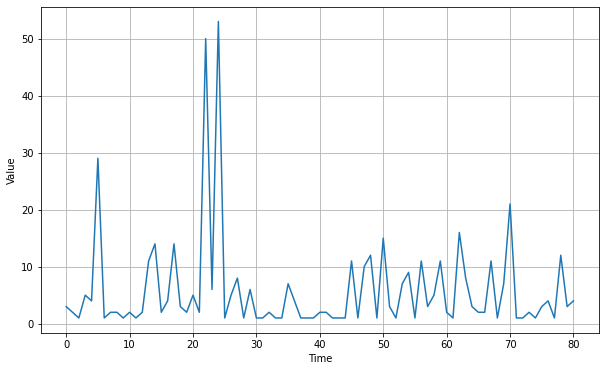

In [82]:
district = 'Puttalam'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district) 

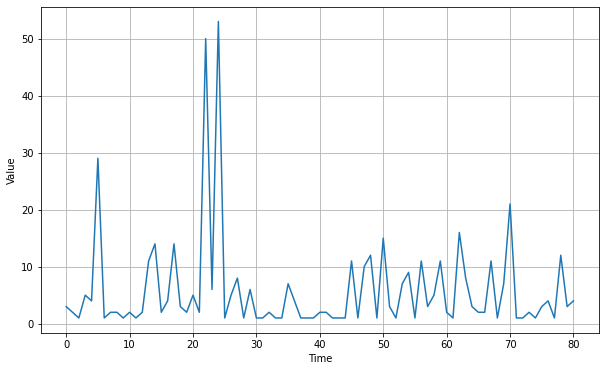

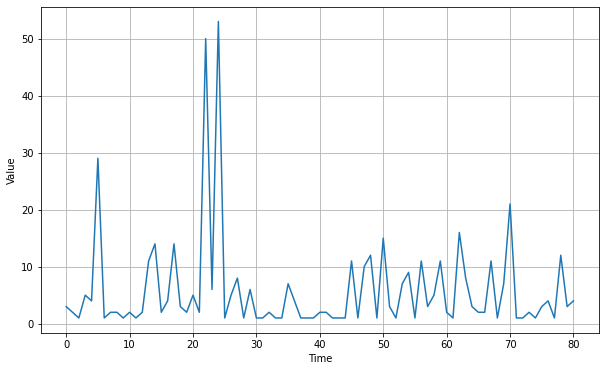

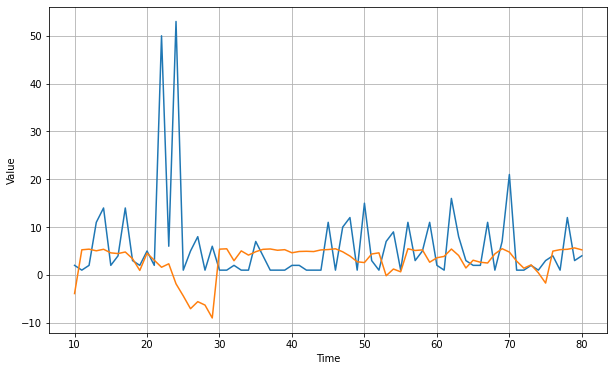

In [83]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 23.4366 - mae: 23.9366
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 23.4317 - mae: 23.9317
Epoch 3/300
1/1 [==============================] - 0s 997us/step - loss: 23.4225 - mae: 23.9225
Epoch 4/300
1/1 [==============================] - 0s 998us/step - loss: 23.4094 - mae: 23.9094
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 23.3928 - mae: 23.8928
Epoch 6/300
1/1 [==============================] - 0s 993us/step - loss: 23.3731 - mae: 23.8731
Epoch 7/300
1/1 [==============================] - 0s 952us/step - loss: 23.3505 - mae: 23.8505
Epoch 8/300
1/1 [==============================] - 0s 999us/step - loss: 23.3256 - mae: 23.8256
Epoch 9/300
1/1 [==============================] - 0s 998us/step - loss: 23.2986 - mae: 23.7986
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 23.2698 - mae: 23.7698
Epoch 11/300
1/1 [=============================

1/1 [==============================] - 0s 1ms/step - loss: 17.7061 - mae: 18.1807
Epoch 171/300
1/1 [==============================] - 0s 2ms/step - loss: 17.6833 - mae: 18.1591
Epoch 172/300
1/1 [==============================] - 0s 998us/step - loss: 17.6606 - mae: 18.1375
Epoch 173/300
1/1 [==============================] - 0s 996us/step - loss: 17.6380 - mae: 18.1159
Epoch 174/300
1/1 [==============================] - 0s 998us/step - loss: 17.6154 - mae: 18.0944
Epoch 175/300
1/1 [==============================] - 0s 998us/step - loss: 17.5930 - mae: 18.0729
Epoch 176/300
1/1 [==============================] - 0s 999us/step - loss: 17.5702 - mae: 18.0511
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 17.5475 - mae: 18.0294
Epoch 178/300
1/1 [==============================] - 0s 998us/step - loss: 17.5248 - mae: 18.0076
Epoch 179/300
1/1 [==============================] - 0s 996us/step - loss: 17.5021 - mae: 17.9858
Epoch 180/300
1/1 [=====================

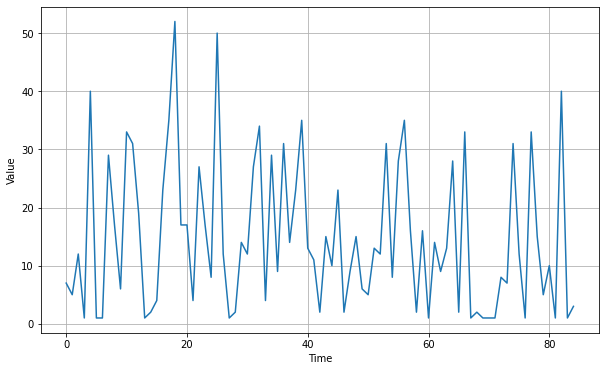

In [84]:
district = 'Ratnapura'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district) 

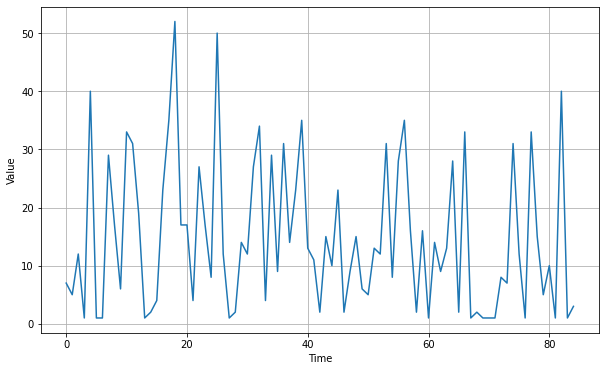

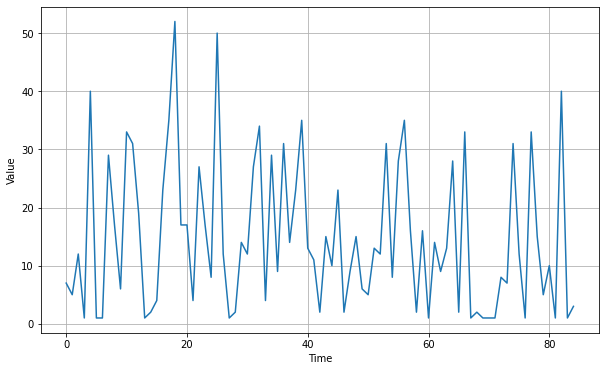

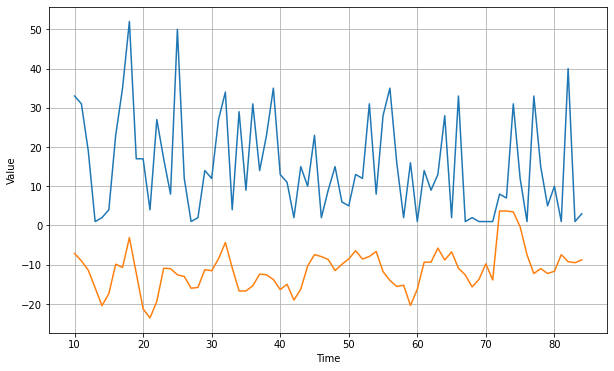

In [85]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 8ms/step - loss: 14.6809 - mae: 15.1809
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 14.6772 - mae: 15.1772
Epoch 3/300
1/1 [==============================] - 0s 0s/step - loss: 14.6704 - mae: 15.1704
Epoch 4/300
1/1 [==============================] - 0s 978us/step - loss: 14.6606 - mae: 15.1606
Epoch 5/300
1/1 [==============================] - 0s 998us/step - loss: 14.6483 - mae: 15.1483
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 14.6338 - mae: 15.1338
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 14.6172 - mae: 15.1172
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 14.5990 - mae: 15.0990
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 14.5793 - mae: 15.0793
Epoch 10/300
1/1 [==============================] - 0s 998us/step - loss: 14.5584 - mae: 15.0584
Epoch 11/300
1/1 [==============================] - 0s

1/1 [==============================] - 0s 2ms/step - loss: 10.8138 - mae: 11.2886
Epoch 171/300
1/1 [==============================] - 0s 996us/step - loss: 10.7996 - mae: 11.2747
Epoch 172/300
1/1 [==============================] - 0s 1ms/step - loss: 10.7854 - mae: 11.2607
Epoch 173/300
1/1 [==============================] - 0s 997us/step - loss: 10.7713 - mae: 11.2467
Epoch 174/300
1/1 [==============================] - 0s 2ms/step - loss: 10.7573 - mae: 11.2327
Epoch 175/300
1/1 [==============================] - 0s 2ms/step - loss: 10.7434 - mae: 11.2188
Epoch 176/300
1/1 [==============================] - 0s 997us/step - loss: 10.7296 - mae: 11.2049
Epoch 177/300
1/1 [==============================] - 0s 2ms/step - loss: 10.7159 - mae: 11.1911
Epoch 178/300
1/1 [==============================] - 0s 998us/step - loss: 10.7023 - mae: 11.1773
Epoch 179/300
1/1 [==============================] - 0s 1ms/step - loss: 10.6887 - mae: 11.1636
Epoch 180/300
1/1 [===========================

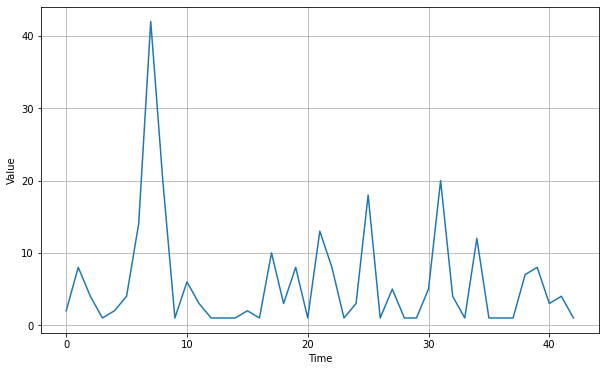

In [86]:
district = 'Trincomalee'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district) 

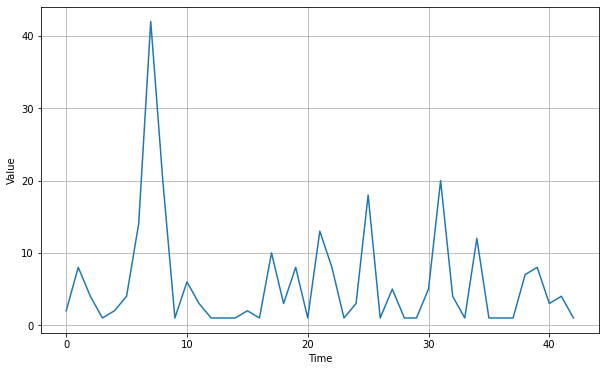

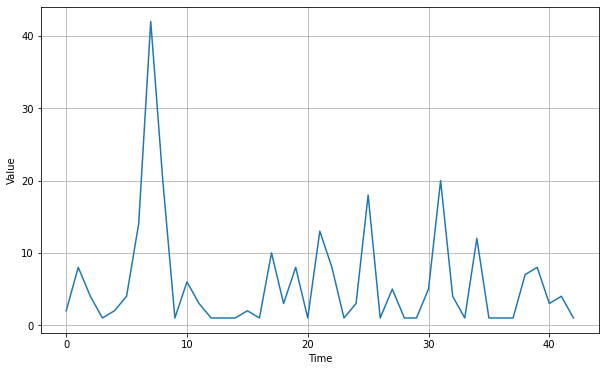

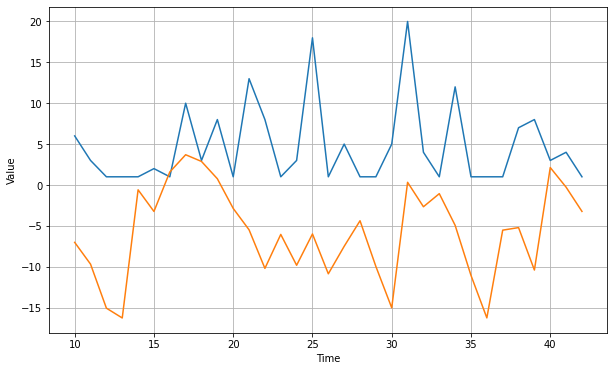

In [87]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 7ms/step - loss: 6.6052 - mae: 7.1052
Epoch 2/300
1/1 [==============================] - 0s 996us/step - loss: 6.6012 - mae: 7.1012
Epoch 3/300
1/1 [==============================] - 0s 990us/step - loss: 6.5936 - mae: 7.0936
Epoch 4/300
1/1 [==============================] - 0s 989us/step - loss: 6.5827 - mae: 7.0827
Epoch 5/300
1/1 [==============================] - 0s 996us/step - loss: 6.5688 - mae: 7.0688
Epoch 6/300
1/1 [==============================] - 0s 997us/step - loss: 6.5524 - mae: 7.0524
Epoch 7/300
1/1 [==============================] - 0s 998us/step - loss: 6.5335 - mae: 7.0335
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 6.5126 - mae: 7.0126
Epoch 9/300
1/1 [==============================] - 0s 998us/step - loss: 6.4898 - mae: 6.9898
Epoch 10/300
1/1 [==============================] - 0s 985us/step - loss: 6.4653 - mae: 6.9653
Epoch 11/300
1/1 [==============================] - 0s 0s/step 

1/1 [==============================] - 0s 1ms/step - loss: 3.5601 - mae: 4.0548
Epoch 175/300
1/1 [==============================] - 0s 997us/step - loss: 3.5556 - mae: 4.0504
Epoch 176/300
1/1 [==============================] - 0s 998us/step - loss: 3.5511 - mae: 4.0461
Epoch 177/300
1/1 [==============================] - 0s 2ms/step - loss: 3.5467 - mae: 4.0418
Epoch 178/300
1/1 [==============================] - 0s 996us/step - loss: 3.5423 - mae: 4.0375
Epoch 179/300
1/1 [==============================] - 0s 1ms/step - loss: 3.5380 - mae: 4.0333
Epoch 180/300
1/1 [==============================] - 0s 998us/step - loss: 3.5337 - mae: 4.0291
Epoch 181/300
1/1 [==============================] - 0s 997us/step - loss: 3.5295 - mae: 4.0249
Epoch 182/300
1/1 [==============================] - 0s 998us/step - loss: 3.5253 - mae: 4.0207
Epoch 183/300
1/1 [==============================] - 0s 997us/step - loss: 3.5212 - mae: 4.0166
Epoch 184/300
1/1 [==============================] - 0s 1ms/

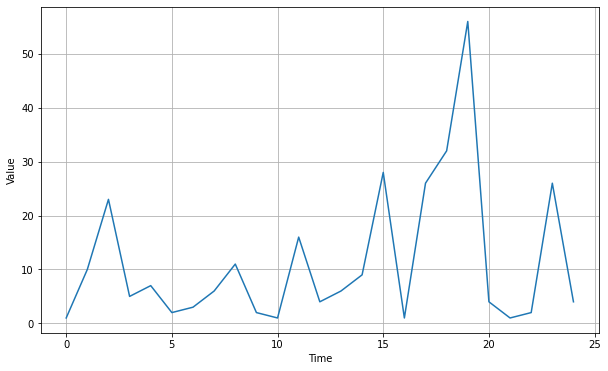

In [88]:
district = 'Vavuniya'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, district) 

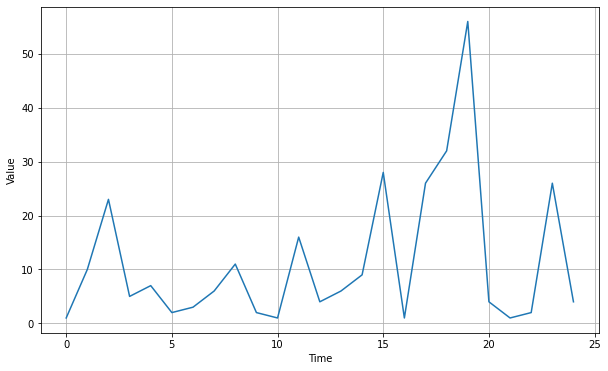

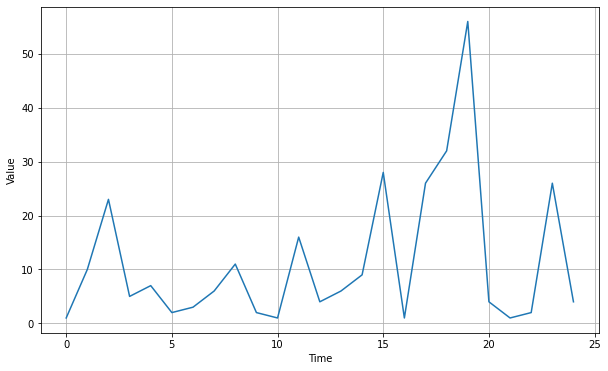

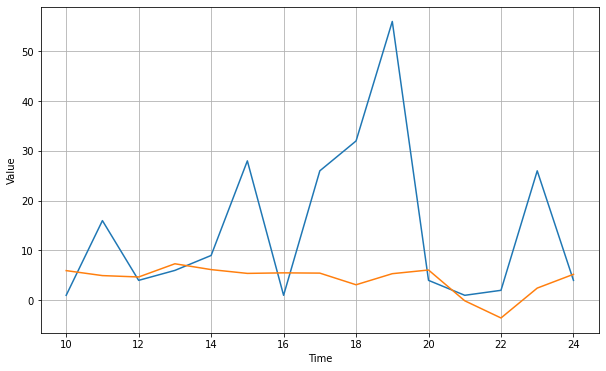

In [89]:
series, time = open_and_read(district)
time_train, x_train, time_valid, x_valid = steps_split(split, district)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)